# **Exploratory Data Analysis (EDA) for data science and ML**

**Overview**
- Objectives
- Setup
- Regression
- Perform EDA
- Histograms and boxplots
- Correlation matrix
- Pair plots
- A simple function to perform EDA
- Classification

In [3]:
import random
random.seed(2004)

import missingno as msno
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.datasets import load_diabetes, load_iris
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

from fasteda import fast_eda

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

sns.set_context('notebook')
sns.set_style('white')

## Load the diabetes data set


In [4]:
#The following code loads the diabetes data set from sklearn and prints out a description of the data.
import pandas as pd
from sklearn.datasets import load_diabetes

# Load the diabetes dataset from sklearn
diabetes_X, diabetes_y = load_diabetes(return_X_y=True, as_frame=True, scaled=False)

# Concentrate the two pandas.DataFrames into one
diabetes = pd.concat([diabetes_X, pd.Series(diabetes_y)], axis=1).rename({0:'target'}, axis=1)

# Load the diabetes dataset using another method to print the dataset description
diabetes_default = load_diabetes()

# Print the dataset description
print(diabetes_default['DESCR'])


.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

:Number of Instances: 442

:Number of Attributes: First 10 columns are numeric predictive values

:Target: Column 11 is a quantitative measure of disease progression one year after baseline

:Attribute Information:
    - age     age in years
    - sex
    - bmi     body mass index
    - bp      average blood pressure
    - s1      tc, total serum cholesterol
    - s2      ldl, low-density lipoproteins
    - s3      hdl, high-density lipoproteins
    - s4      tch, total cholesterol / HDL
    - s5      ltg, possibly log of serum triglycerides level
    - s6      glu, blood sugar level

Note: Each of these 10 feature variables have bee

In [5]:
diabetes.sample(5)

age  sex   bmi     bp     s1     s2    s3   s4      s5     s6  target
335  50.0  1.0  21.9   91.0  190.0  111.2  67.0  3.0  4.0775   77.0    96.0
438  47.0  2.0  24.9   75.0  225.0  166.0  42.0  5.0  4.4427  102.0   104.0
31   42.0  1.0  20.3   71.0  161.0   81.2  66.0  2.0  4.2341   81.0    59.0
350  41.0  2.0  32.0  126.0  198.0  104.2  49.0  4.0  5.4116  124.0   243.0
329  45.0  2.0  21.2   94.0  169.0   96.8  55.0  3.0  4.4543  102.0   135.0

---

The original data set does not contain any missing values. 
To verify this, run the following code, which outputs `True` if there are missing values and `False` otherwise.

In [6]:
diabetes.isna().max(axis=0).max()

False

To derive the most benefit from this EDA exercise, you introduce some missing values. Specifically, you select 3 feature columns at random, and set them to missing for 10% of randomly selected rows.

In [7]:
# set the random seed for reproducibility
random.seed(2024)

# select 3 columns at random
missing_cols = random.sample(range(len(diabetes.columns)-1),3)

# select 10% rows at random
missing_rows = random.sample(diabetes.index.tolist(), int(np.round(len(diabetes.index.tolist())/10)))

# set the 3 selected columns to missing values for 10% of selected rows
diabetes.iloc[missing_rows, missing_cols] = np.nan

To see which columns were randomly selected, run the following cell.

In [8]:
print(sorted(diabetes.columns[missing_cols]))

['bmi', 's1', 's4']


You see that `bmi`, `s1`, and `s4` have been randomly selected, resulting in missing values in these columns. It's important to note that although these columns were selected randomly, the use of the `random.seed()` method in the previous code block ensures that the exact same random realization occurs every time the previous code is executed.


---

## Initial data preprocessing and One-Hot Encoder

In [9]:
# intialize one-hot encoder
enc1 = OneHotEncoder(handle_unknown = 'ignore', drop=None)

# One-hot encode 'sex'; the output is a numpy array
encoded_sex = enc1.fit_transform(diabetes[['sex']]).toarray() 

# Convert numpy array to pandas DataFrame with columns names based on original category labels
encoded_sex = pd.DataFrame(encoded_sex, columns=['sex' + str(int(x)) for x in enc1.categories_[0]])

# Horizontally concatenate the original 'diabetes' data set with the two one-hot columns
diabetes = pd.concat([diabetes, encoded_sex], axis=1)

# Sample 10 rows. Print only the 'sex', 'sex1', and 'sex2' columns for simplicity
diabetes[['sex','sex1','sex2']].sample(10)

sex  sex1  sex2
120  1.0   1.0   0.0
379  1.0   1.0   0.0
8    2.0   0.0   1.0
221  1.0   1.0   0.0
229  2.0   0.0   1.0
281  2.0   0.0   1.0
361  1.0   1.0   0.0
421  2.0   0.0   1.0
213  1.0   1.0   0.0
52   1.0   1.0   0.0

In [10]:
diabetes = diabetes.drop(['sex','sex2'], axis=1)  # Drop 'sex' and 'sex2' columns
diabetes = diabetes.loc[:, ['age','sex1','bmi','bp','s1','s2','s3','s4','s5','s6','target']]  # Reorder columns
print(diabetes.sample(5))  # Print a random sample of 5 rows

      age  sex1   bmi     bp     s1     s2    s3    s4      s5    s6  target
413  34.0   1.0  26.3  87.00  197.0  120.0  63.0  3.00  4.2485  96.0   113.0
396  25.0   0.0   NaN  88.00    NaN   80.8  55.0   NaN  3.5835  83.0    43.0
237  64.0   1.0  20.0  74.67  189.0  114.8  62.0  3.05  4.1109  91.0    72.0
174  53.0   0.0  27.3  82.00  119.0   55.0  39.0  3.00  4.8283  93.0   151.0
406  33.0   1.0  18.9  70.00  162.0   91.8  59.0  3.00  4.0254  58.0    72.0


### Make a train-test split

In [11]:
# make a train, test split
X_train,x_test, y_train,y_test = train_test_split(diabetes.iloc[:, :-1], diabetes.iloc[:, :-1], test_size=0.33, random_state=2024 )

## Perform EDA

### A look at the beginning and end of the data set

In [12]:
diabetes.head()

age  sex1   bmi     bp     s1     s2    s3   s4      s5    s6  target
0  59.0   0.0  32.1  101.0  157.0   93.2  38.0  4.0  4.8598  87.0   151.0
1  48.0   1.0  21.6   87.0  183.0  103.2  70.0  3.0  3.8918  69.0    75.0
2  72.0   0.0  30.5   93.0  156.0   93.6  41.0  4.0  4.6728  85.0   141.0
3  24.0   1.0  25.3   84.0  198.0  131.4  40.0  5.0  4.8903  89.0   206.0
4  50.0   1.0  23.0  101.0  192.0  125.4  52.0  4.0  4.2905  80.0   135.0

In [13]:
diabetes.tail()

age  sex1   bmi      bp     s1     s2    s3    s4      s5     s6  target
437  60.0   0.0  28.2  112.00  185.0  113.8  42.0  4.00  4.9836   93.0   178.0
438  47.0   0.0  24.9   75.00  225.0  166.0  42.0  5.00  4.4427  102.0   104.0
439  60.0   0.0  24.9   99.67  162.0  106.6  43.0  3.77  4.1271   95.0   132.0
440  36.0   1.0  30.0   95.00  201.0  125.2  42.0  4.79  5.1299   85.0   220.0
441  36.0   1.0  19.6   71.00  250.0  133.2  97.0  3.00  4.5951   92.0    57.0

In [14]:
diabetes.describe()

age        sex1         bmi          bp          s1          s2  \
count  442.000000  442.000000  398.000000  442.000000  398.000000  442.000000   
mean    48.518100    0.531674   26.425879   94.647014  189.266332  115.439140   
std     13.109028    0.499561    4.445336   13.831283   34.391866   30.413081   
min     19.000000    0.000000   18.000000   62.000000   97.000000   41.600000   
25%     38.250000    0.000000   23.125000   84.000000  165.000000   96.050000   
50%     50.000000    1.000000   25.800000   93.000000  186.000000  113.000000   
75%     59.000000    1.000000   29.500000  105.000000  209.000000  134.500000   
max     79.000000    1.000000   42.200000  133.000000  301.000000  242.400000   

               s3          s4          s5          s6      target  
count  442.000000  398.000000  442.000000  442.000000  442.000000  
mean    49.788462    4.075075    4.641411   91.260181  152.133484  
std     12.934202    1.282526    0.522391   11.496335   77.093005  
min     22.000000    2.000000    3.258100   58.000000   25.000000  
25%     40.250000    3.000000    4.276700   83.250000   87.000000  
50%     48.000000    4.000000    4.620050   91.000000  140.500000  
75%     57.750000    5.000000    4.997200   98.000000  211.500000  
max     99.000000    9.090000    6.107000  124.000000  346.000000

The description table provides many useful statistics regarding the data set:
- The `count` row indicates the number of non-missing observations in each column.
- The `mean` row provides, for each column, the [arithmetic mean](https://en.wikipedia.org/wiki/Arithmetic_mean) for all non-missing observations.
- The `std` row provides, for each column, the [standard deviation](https://en.wikipedia.org/wiki/Standard_deviation) for all non-missing observations.
- The `min` row provides, for each column, the minimum value for all non-missing observations.
- The `25%`, `50%`, and `75%` rows provide [quartiles](https://en.wikipedia.org/wiki/Quartile) for each column.
- The `max` row provides, for each column, the maximum value for all non-missing observations.

The description table offers initial hints about potential anomalies in the data. For example, if a column's maximum value is unusually high compared to its mean and standard deviation, it might suggest the presence of an outlier or measurement error, requiring further investigation.

Consider the following facts:
 - `diabetes` is a `pandas.DataFrame`.
 - `isna()` is a `pandas.DataFrame` method that returns another `pandas.DataFrame` with `True` where values are missing and `False` otherwise.
 - `sum()` is a method that returns the sum across all rows for every column in a `pandas.DataFrame`.
 - When summing binary data in Python, `True` takes the interger value `1`, and `False` takes the interger value `0`.

Given the previous information, write one line of code that shows the number of missing values for every column in the `diabetes` DataFrame.

In [15]:
diabetes.isna().sum()

age        0
sex1       0
bmi       44
bp         0
s1        44
s2         0
s3         0
s4        44
s5         0
s6         0
target     0
dtype: int64

The `missingno` package, imported as `msno`, has a function named `matrix()`, which accepts a `pandas.DataFrame` as the first positional argument. Call the `matrix()` function on the `diabetes` DataFrame.

<Axes: >

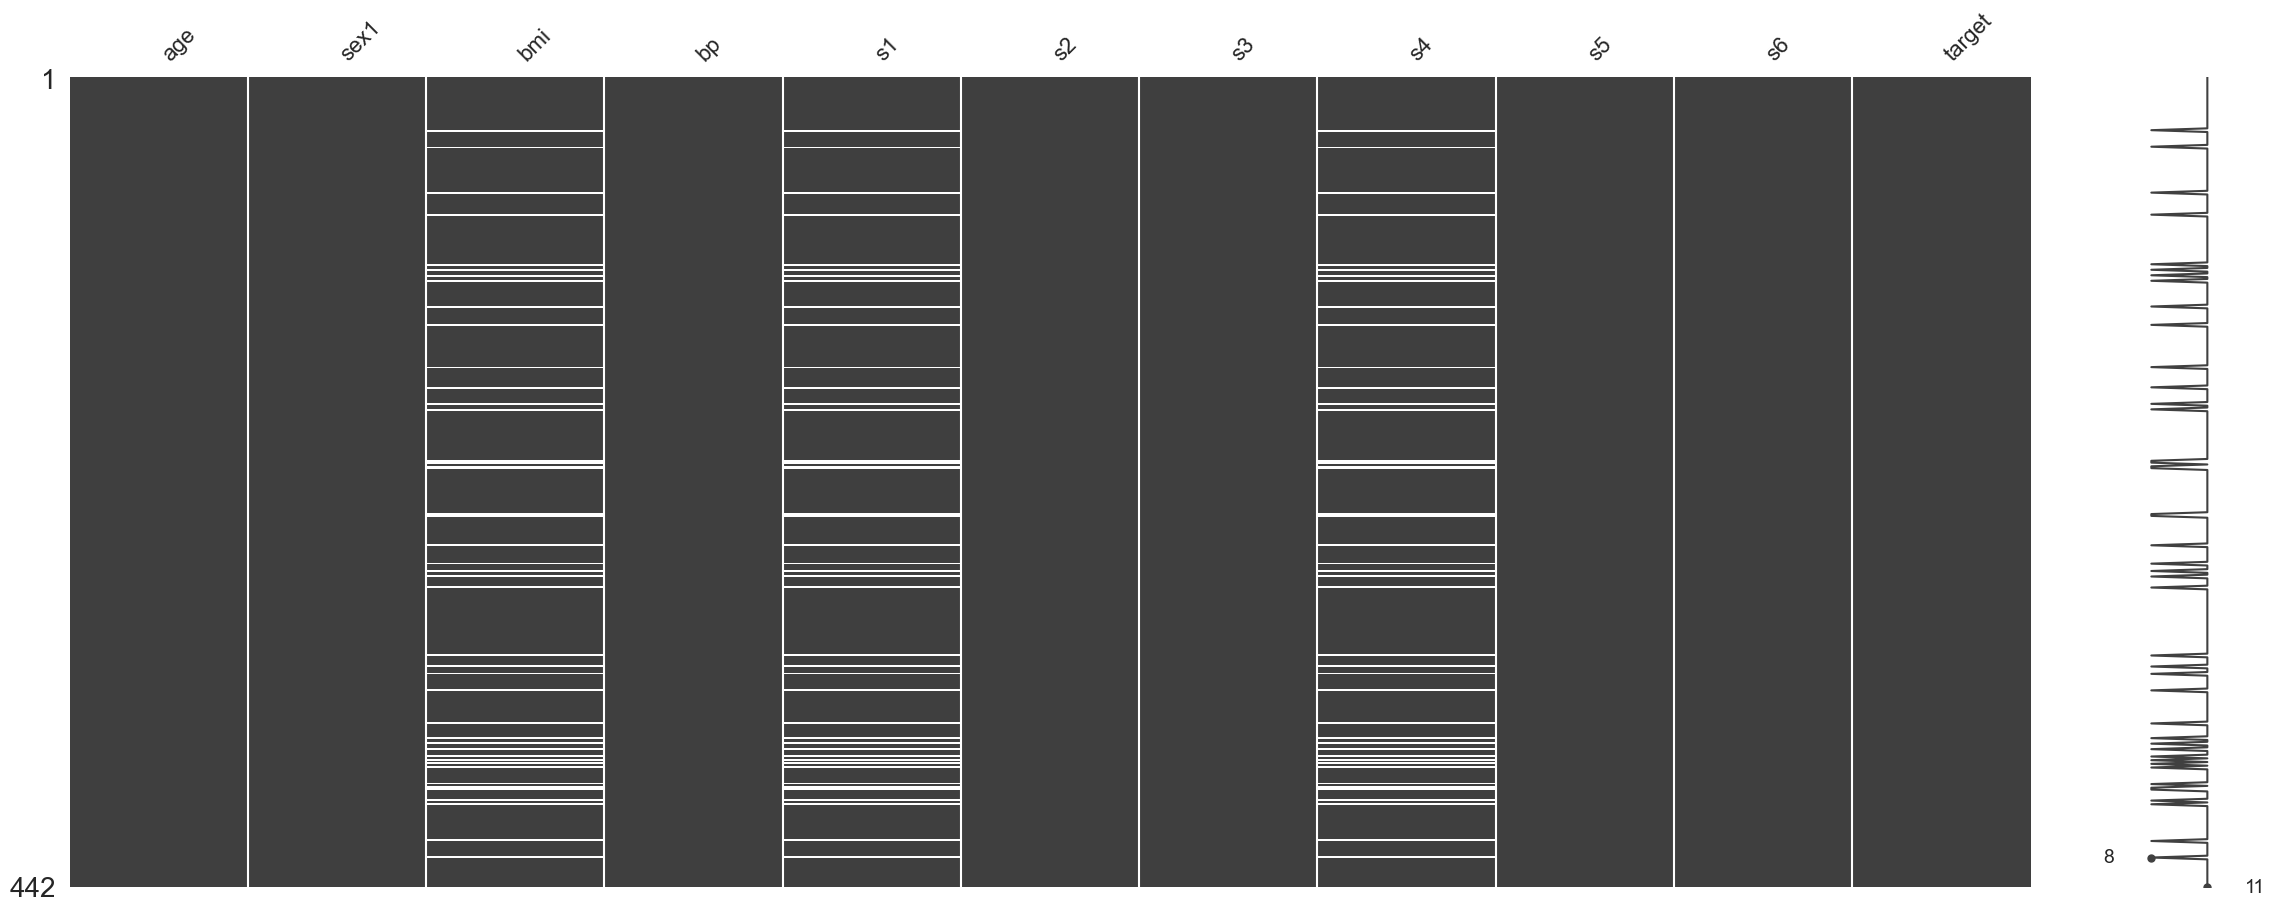

In [16]:
msno.matrix(diabetes)

In [17]:
diabetes.index[diabetes['bmi'].isna()][10]

158

You can see that, in fact, the first 158 rows do not have missing values.

There are typically three different strategies for dealing with data that is missing at random:
- Dropping the observations with missing data
- Filling the observations with missing data with the mean
- Filling the observations with missing data with the median

### Drop missing observations

- [linear regression](https://en.wikipedia.org/wiki/Linear_regression)
 - [root mean squared error](https://en.wikipedia.org/wiki/Root-mean-square_deviation)

In [18]:
# Linear Regression by dropping NAN's

# Get the NAN indices
nonnan_train_indices = X_train.index[~X_train.isna().max(axis=1)]
nonnan_test_indices = x_test.index[~x_test.isna().max(axis=1)]

# Fit instance of Linear Regression
reg = LinearRegression().fit(X_train.loc[nonnan_train_indices], y_train.loc[nonnan_train_indices])

# Generate Predictions
pred = reg.predict(x_test.loc[nonnan_test_indices])

# Calculate the MSE (Mean Squared Error)
root_mean_squared_error(y_test.loc[nonnan_test_indices], pred)

1.329089999510364e-14

You end up with an RMSE of around 1.329.
How good is an RMSE of 1.329? Well, you won't really know unless you compare the performance of this model to a few different model specifications. See if you can improve on the performance of this baseline prediction model using the information obtained by EDA.

### Fill in missing values with the mean.

In [19]:
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

# Remove rows where y_train or X_train has NaN values
mask = ~y_train.isna()  # Create a mask to filter out NaNs in y_train
X_train_cleaned = X_train[mask]  # Apply mask to X_train
y_train_cleaned = y_train[mask]  # Apply mask to y_train

# Check if there are still any NaN values in y_train_cleaned
if y_train_cleaned.isna().any():
    raise ValueError("y_train_cleaned still contains NaN values.")

# Get the NAN indices for the test set
nonnan_test_indices = x_test.index[~x_test.isna().max(axis=1)]

# Initiate the simple imputer
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')

# Fit the simple imputer with the training data
imp_mean.fit(X_train_cleaned)

# Impute the training data
X_train_mean_filled = imp_mean.transform(X_train_cleaned)

# Fit an instance of Linear Regression
reg = LinearRegression().fit(X_train_mean_filled, y_train_cleaned)

# Impute the test set data
x_test_mean_filled = imp_mean.transform(x_test)

# Generate the Predictions for the test set
pred = reg.predict(x_test_mean_filled.loc[nonnan_test_indices])

# Calculate the MSE and RMSE
mse = mean_squared_error(y_test.loc[nonnan_test_indices], pred)
rmse = np.sqrt(mse)

print(f'Root Mean Squared Error: {rmse}')


ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

---

### Fill in missing values with the median

Instead of filling in the missing value with the mean, you can also fill it in using the median. Complete the following exercise to fill in missing values using the median.

In [20]:
# linear regression with median fill

# Get NAN indices
nonnan_train_indices = X_train.index[~X_train.isna().max(axis=1)]
nonnan_test_indices = x_test.index[~x_test.isna().max(axis=1)]

# Initialize the simple imputer
imp_median = SimpleImputer(missing_values=np.nan, strategy='median')
# Fit the simple imputer using the training data
imp_median.fit(X_train)
# Actually median fill the training data
X_train_median_filled = imp_median.transform(X_train)

# Fit an instance of `LinearRegression`
reg = LinearRegression().fit(X_train_median_filled, y_train)
# Generate predictions
pred = reg.predict(x_test.loc[nonnan_test_indices])
# Calculate the root mean squared error
root_mean_squared_error(y_test.loc[nonnan_test_indices],pred)

ValueError: Input y contains NaN.

As observed, median filling yields an RMSE of 55.73, which is practically identical (allowing for rounding errors up to 2 decimal places) to the RMSE obtained with the mean fill strategy. Given their comparable performance, the choice between these strategies is subjective and lies with the data scientist. Considering that median filling is less influenced by extreme values, you opt for median filling in this instance. However, it's worth noting that choosing mean filling would have been equally acceptable.


---

### Histograms and boxplots

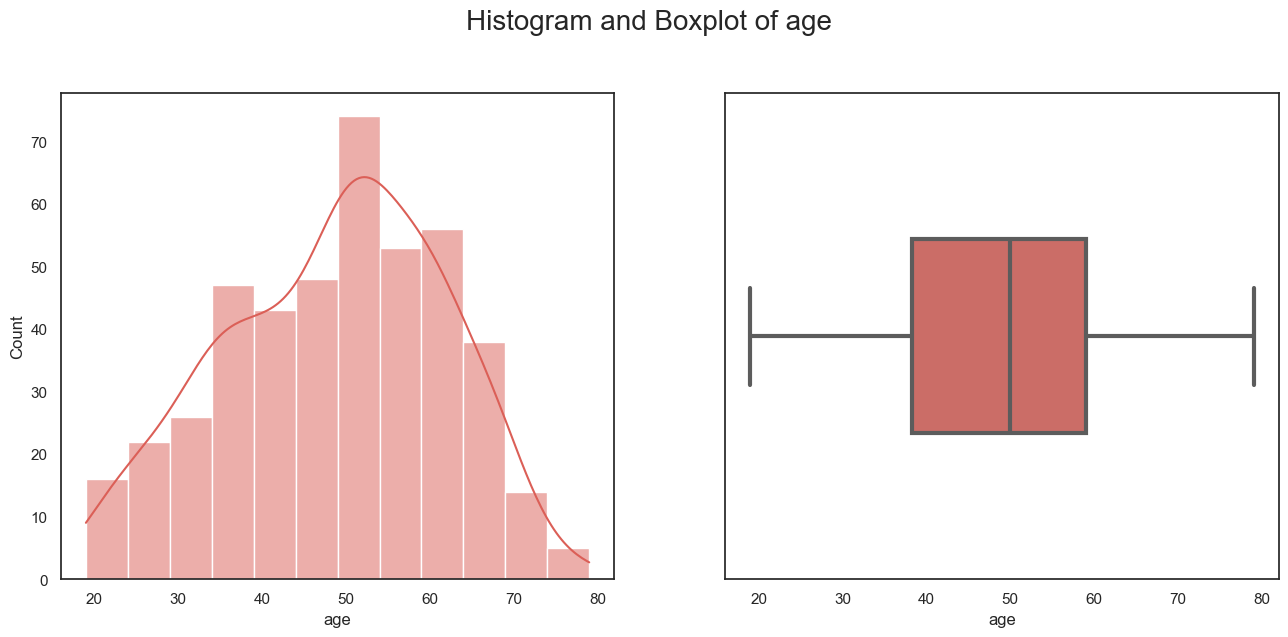

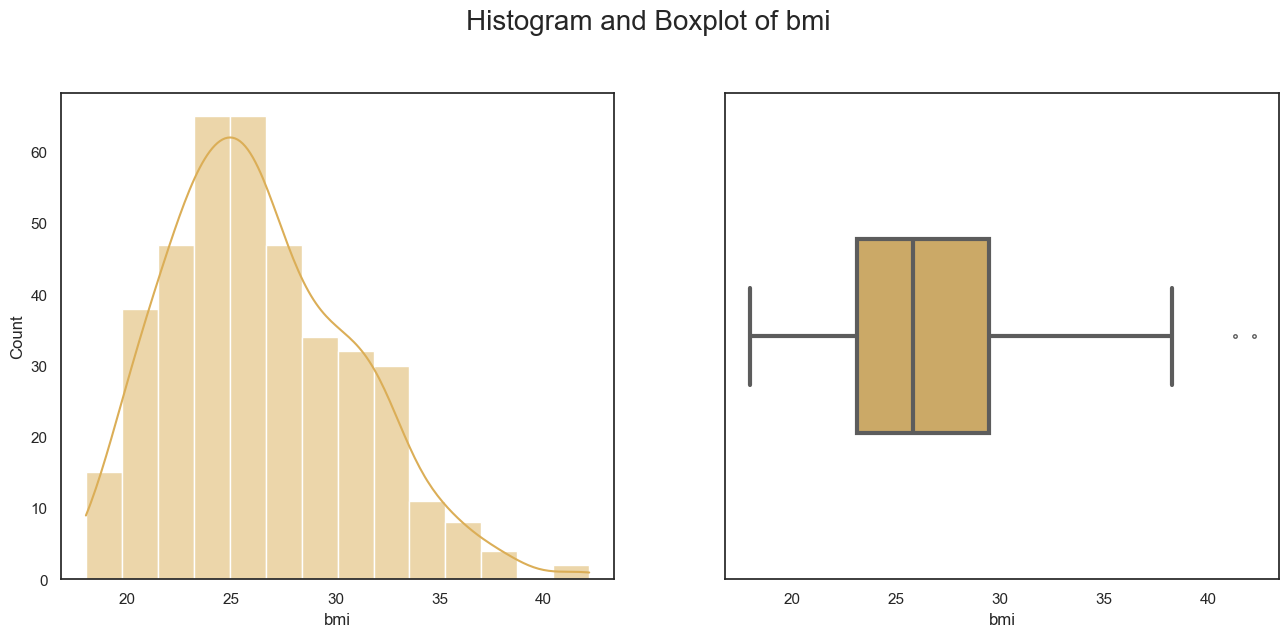

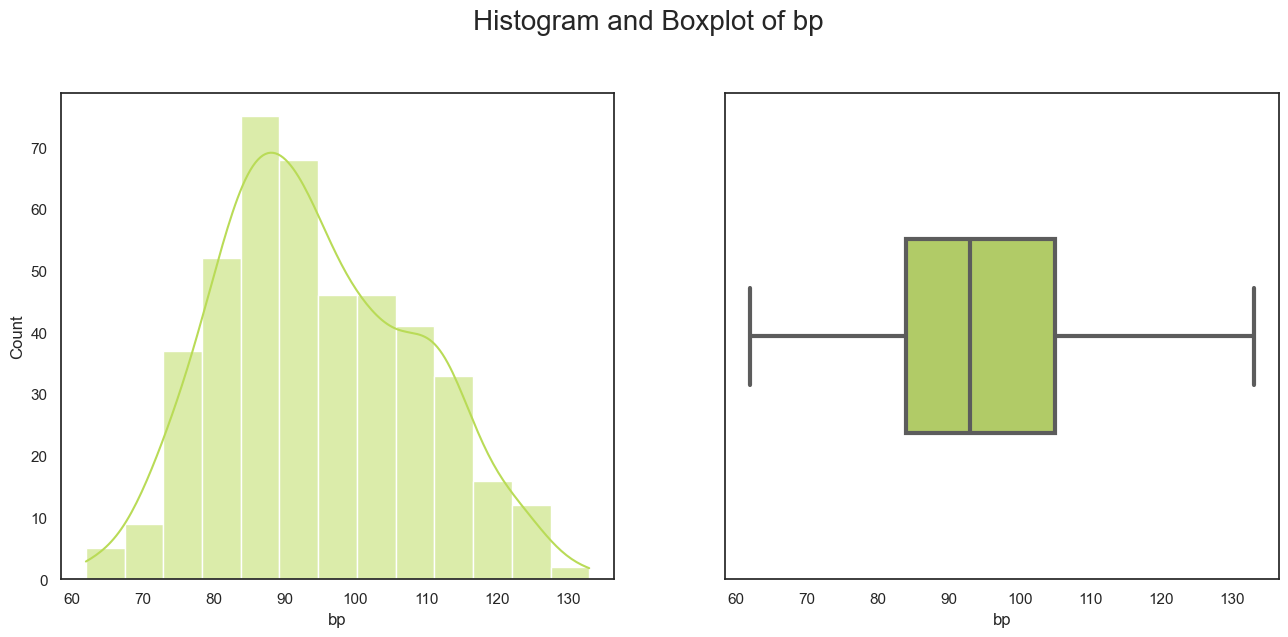

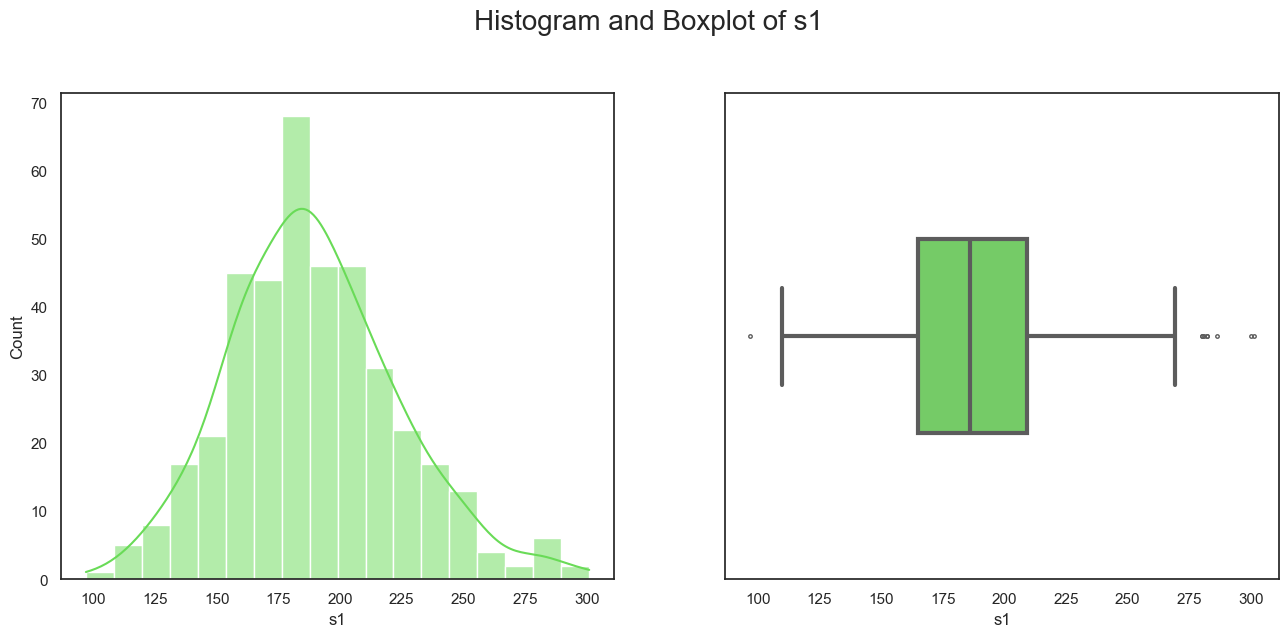

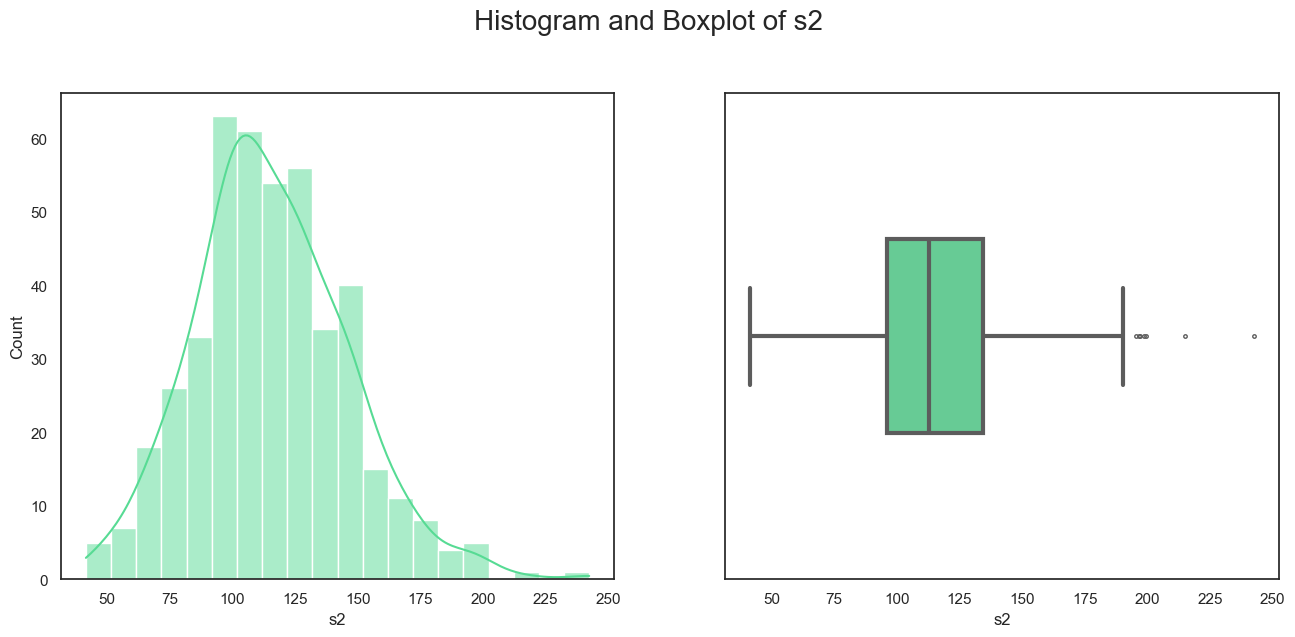

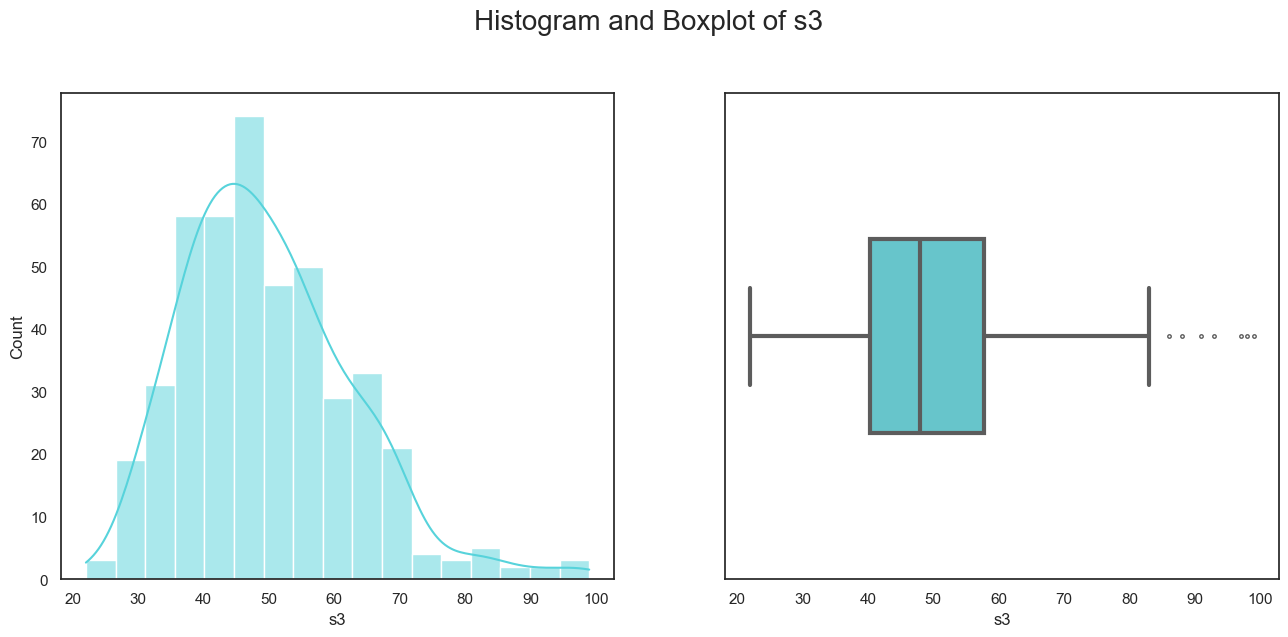

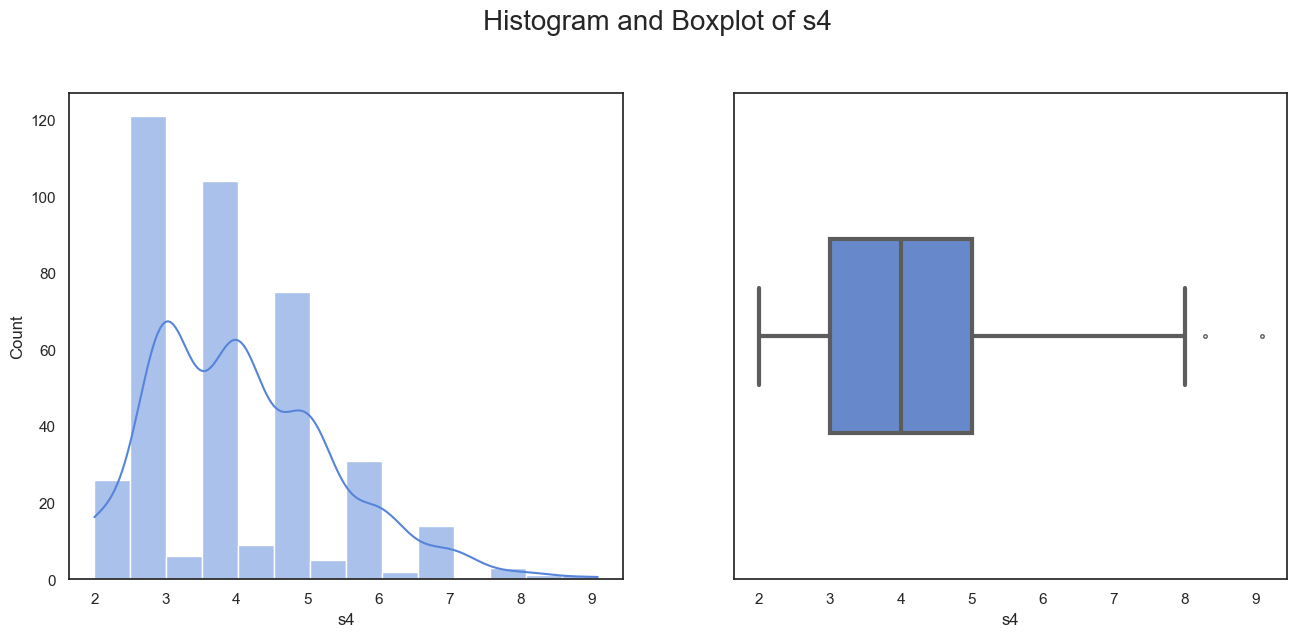

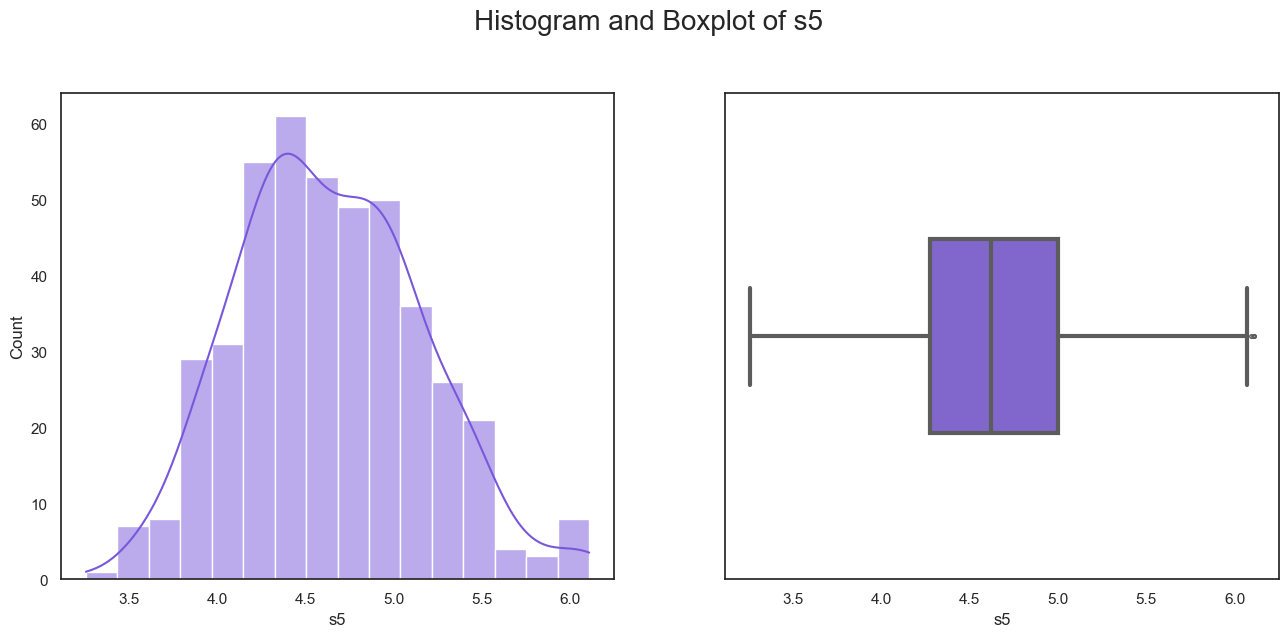

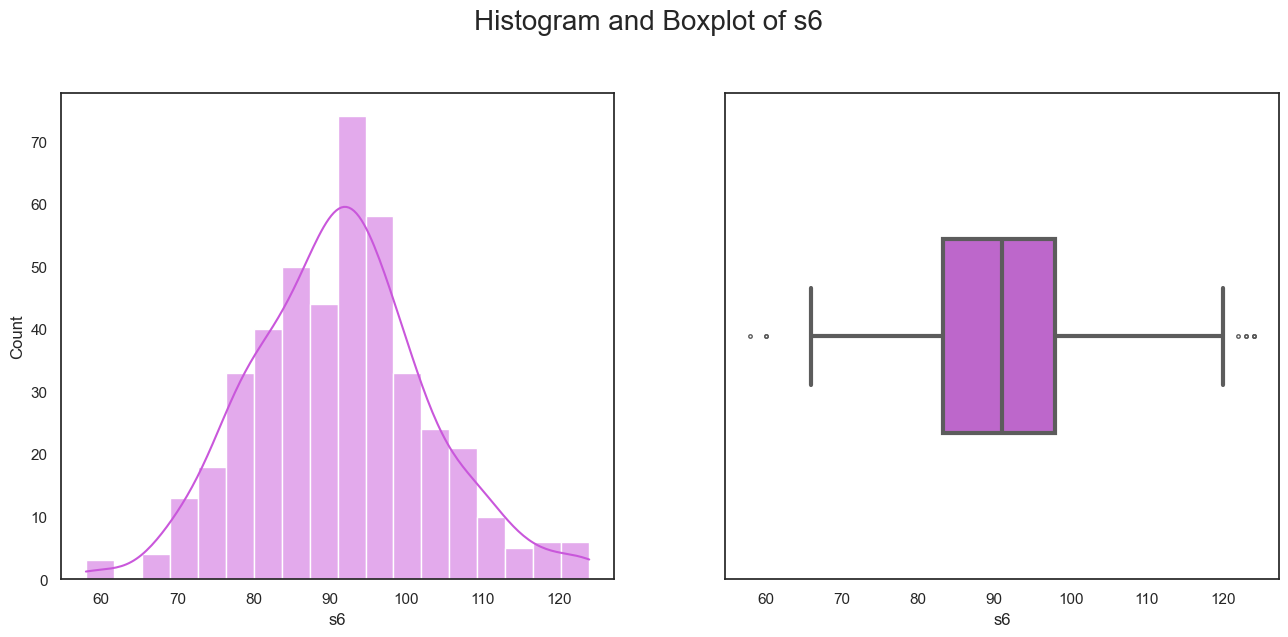

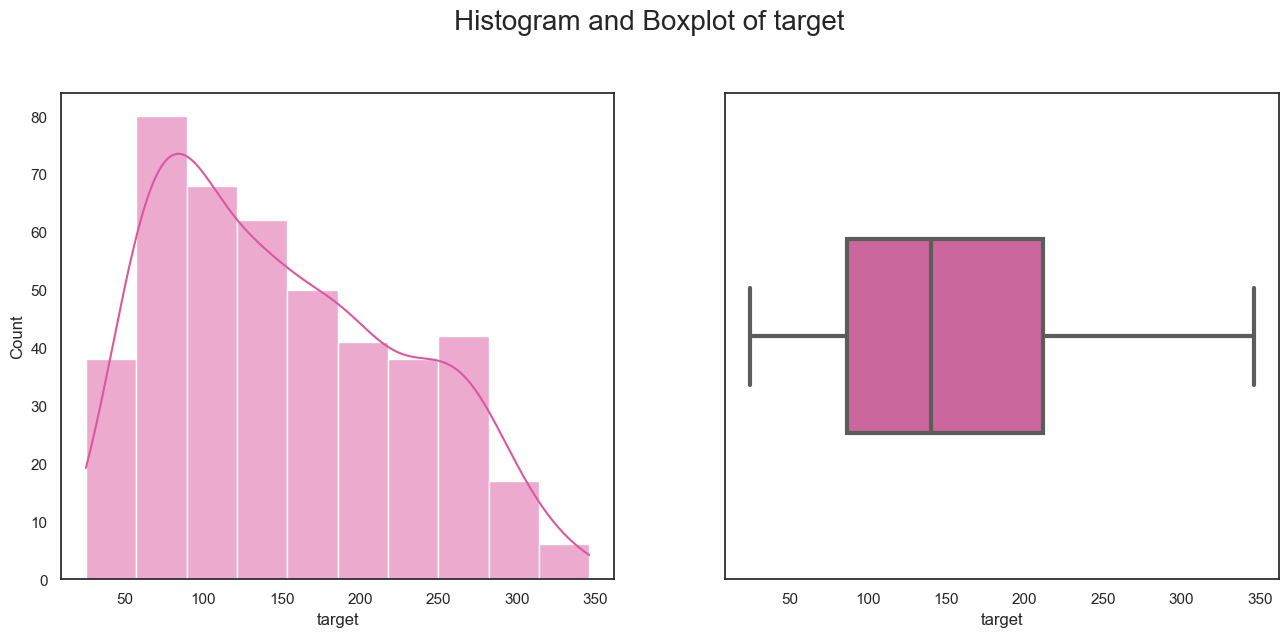

In [21]:
for idx, col in enumerate([i for i in diabetes.columns if i != 'sex1']):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (14, 6))
    sns.histplot(diabetes, x = diabetes[col], kde = True,
                 color = sns.color_palette("hls", len([i for i in diabetes.columns if i != 'sex1']))[idx], ax = ax1)
    sns.boxplot(x = diabetes[col], width = 0.4, linewidth = 3, fliersize = 2.5,
                color = sns.color_palette("hls", len([i for i in diabetes.columns if i != 'sex1']))[idx], ax = ax2)
    fig.suptitle(f"Histogram and Boxplot of {col}", size = 20, y = 1.02)
    plt.show()

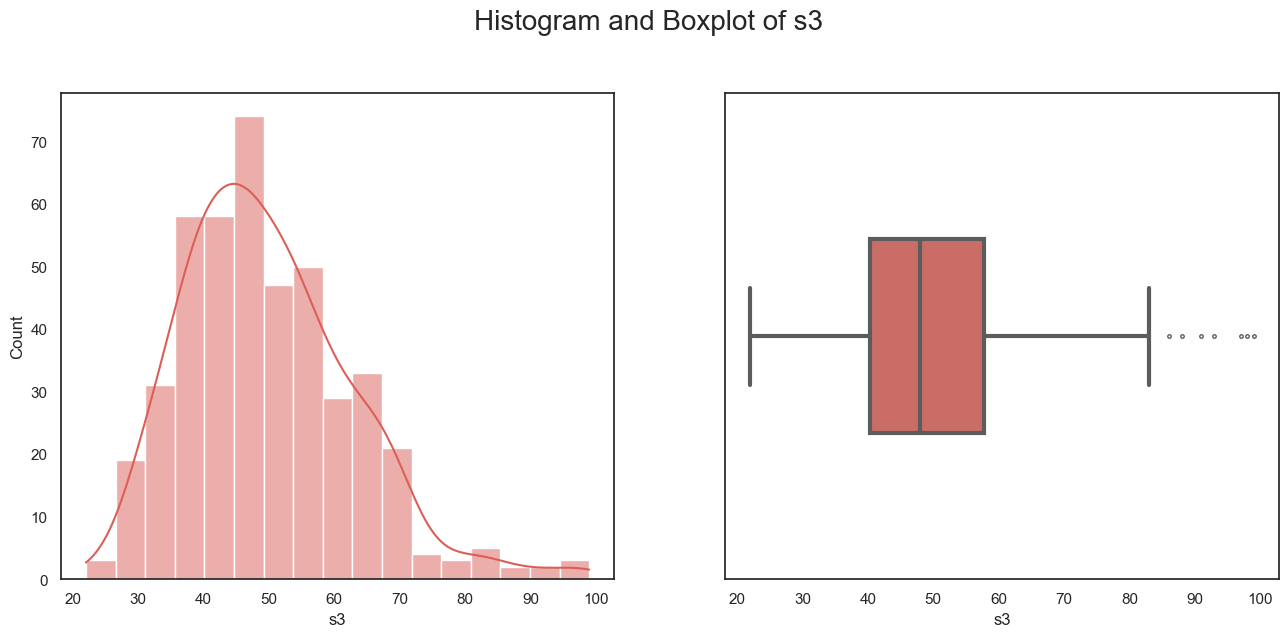

In [22]:
for idx, col in enumerate(['s3']):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (14, 6))
    sns.histplot(diabetes, x = diabetes[col], kde = True,
                 color = sns.color_palette("hls", len(['s3']))[idx], ax = ax1)
    sns.boxplot(x = diabetes[col], width = 0.4, linewidth = 3, fliersize = 2.5,
                color = sns.color_palette("hls", len(['s3']))[idx], ax = ax2)
    fig.suptitle(f"Histogram and Boxplot of {col}", size = 20, y = 1.02)
    plt.show()

 [Shapiro-Wilk test](https://en.wikipedia.org/wiki/Shapiro%E2%80%93Wilk_test).


In [23]:
# normality test on s3
stat, p = shapiro(X_train['s3'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks normally distributed (fail to reject H0)')
else:
    print('Sample does not look normally distributed (reject H0)')

NameError: name 'shapiro' is not defined

Thus, you can clearly see that `s3` is not normally distributed using a combination of:
- EDA (your analysis of the histogram and boxplot)
- Domain knowledge about what this variable represents
- A statistical test

However, the histogram does indicate that the distribution *might* be [log-normal](https://en.wikipedia.org/wiki/Log-normal_distribution), meaning that a natural logarithm of `s3` might be normally distributed. Let's confirm whether this is likely the case using the Shapiro-Wilk test in the following exercise.


---

In [24]:
# normality test on log of s3
stat, p = shapiro(np.log(X_train['s3']))
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks normally distributed (fail to reject H0)')
else:
    print('Sample does not look normally distributed (reject H0)')

NameError: name 'shapiro' is not defined

In [25]:
# linear regression with median fill, and using the log of 's3'

X_train['s3'] = np.log(X_train['s3'])
x_test['s3'] = np.log(x_test['s3'])

# Get NAN indices
nonnan_train_indices = X_train.index[~X_train.isna().max(axis=1)]
nonnan_test_indices = x_test.index[~x_test.isna().max(axis=1)]

# Initialize the simple imputer
imp_median = SimpleImputer(missing_values=np.nan, strategy='median')
# Fit the simple imputer using the training data
imp_median.fit(X_train)
# Actually median fill the training data
X_train_median_filled = imp_median.transform(X_train)

# Fit an instance of `LinearRegression`
reg = LinearRegression().fit(X_train_median_filled, y_train)
# Generate predictions
pred = reg.predict(x_test.loc[nonnan_test_indices])
# Calculate the root mean squared error
root_mean_squared_error(y_test.loc[nonnan_test_indices],pred)

ValueError: Input y contains NaN.

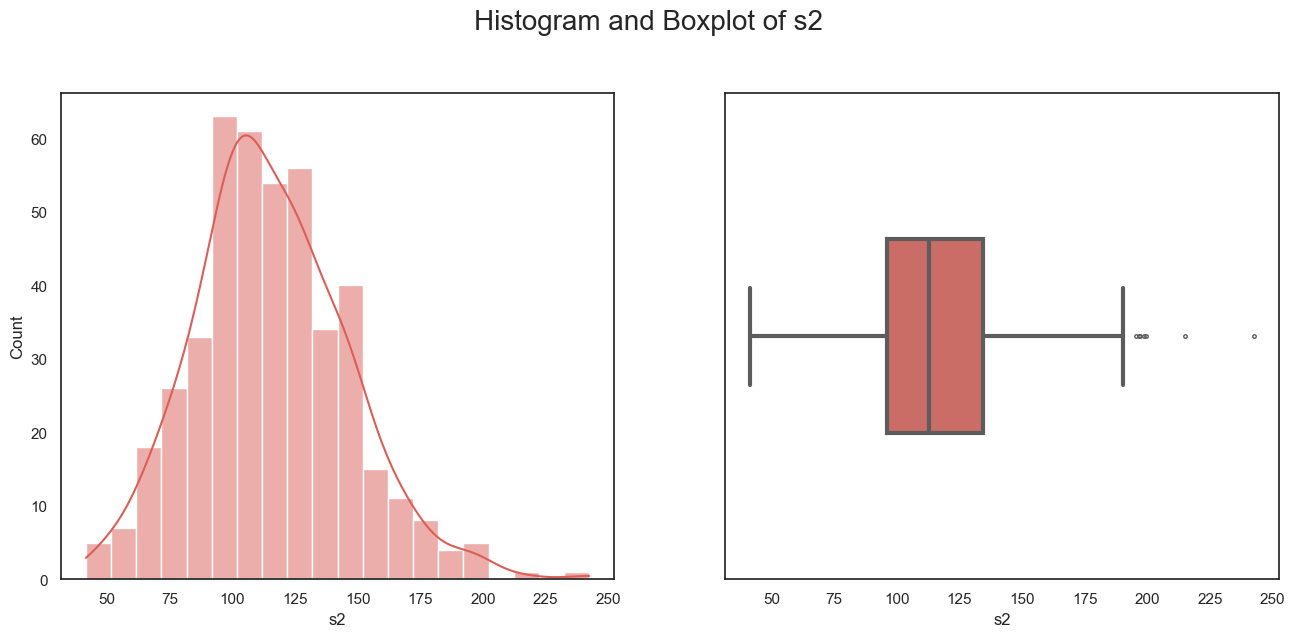

In [26]:
for idx, col in enumerate(['s2']):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (14, 6))
    sns.histplot(diabetes, x = diabetes[col], kde = True,
                 color = sns.color_palette("hls", len(['s2']))[idx], ax = ax1)
    sns.boxplot(x = diabetes[col], width = 0.4, linewidth = 3, fliersize = 2.5,
                color = sns.color_palette("hls", len(['s2']))[idx], ax = ax2)
    fig.suptitle(f"Histogram and Boxplot of {col}", size = 20, y = 1.02)
    plt.show()

In [27]:
# linear regression with median fill, using the log of 's3', and removal of outlier from 's2':

# Outlier removal
X_train_nonoutlier_idx = X_train.index[X_train.s2 < X_train.s2.quantile(0.999)]
X_train = X_train.loc[X_train_nonoutlier_idx]
y_train = y_train.loc[X_train_nonoutlier_idx]

# Get NAN indices
nonnan_train_indices = X_train.index[~X_train.isna().max(axis=1)]
nonnan_test_indices = x_test.index[~x_test.isna().max(axis=1)]

# Initialize the simple imputer
imp_median = SimpleImputer(missing_values=np.nan, strategy='median')
# Fit the simple imputer using the training data
imp_median.fit(X_train)
# Actually median fill the training data
X_train_median_filled = imp_median.transform(X_train)

# Fit an instance of `LinearRegression`
reg = LinearRegression().fit(X_train_median_filled, y_train)
# Generate predictions
pred = reg.predict(x_test.loc[nonnan_test_indices])
# Calculate the root mean squared error
root_mean_squared_error(y_test.loc[nonnan_test_indices],pred)

ValueError: Input y contains NaN.

## Correlation matrix

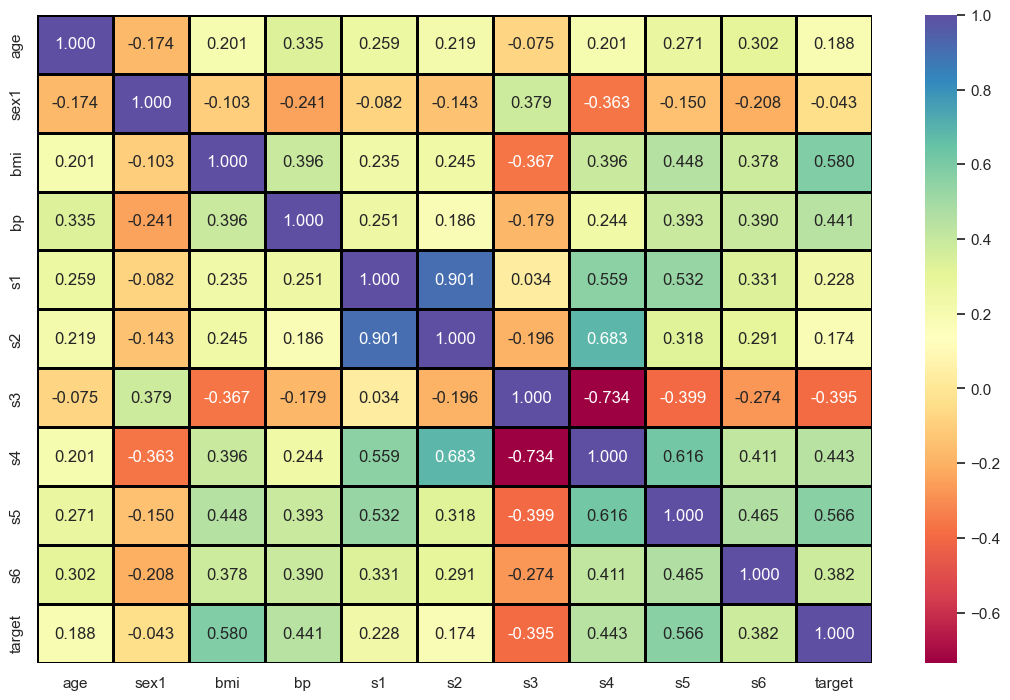

In [28]:
plt.figure(figsize = (12, 8))
sns.heatmap(diabetes.corr(), annot = True, cmap = "Spectral", linewidths = 2, linecolor = "#000000", fmt='.3f')
plt.show()

In [29]:
# linear regression with median fill, using the log of 's3', removal of outlier from 's2', and the dropping of 's1':
"""
# Outlier removal (commented out because `X_train` and `y_train` are already updated)
X_train_nonoutlier_idx = X_train.index[X_train.s2 < X_train.s2.quantile(0.999)]
X_train = X_train.loc[X_train_nonoutlier_idx]
y_train = y_train.loc[X_train_nonoutlier_idx]

# Get NAN indices (commented out because these indices did not change)
nonnan_train_indices = X_train.index[~X_train.isna().max(axis=1)]
nonnan_test_indices = X_test.index[~X_test.isna().max(axis=1)]
"""
# Get column names that do not include 's1'
cols_no_s1 = [i for i in X_train.columns if i != 's1']

# Initialize the simple imputer
imp_median = SimpleImputer(missing_values=np.nan, strategy='median')
# Fit the simple imputer using the training data
imp_median.fit(X_train.loc[:, cols_no_s1])
# Actually median fill the training data
X_train_median_filled = imp_median.transform(X_train.loc[:, cols_no_s1])

# Fit an instance of `LinearRegression`
reg = LinearRegression().fit(X_train_median_filled, y_train)
# Generate predictions
pred = reg.predict(X_test.loc[nonnan_test_indices, cols_no_s1])
# Calculate the root mean squared error
root_mean_squared_error(y_test.loc[nonnan_test_indices],pred)

ValueError: Input y contains NaN.

### Pair plots

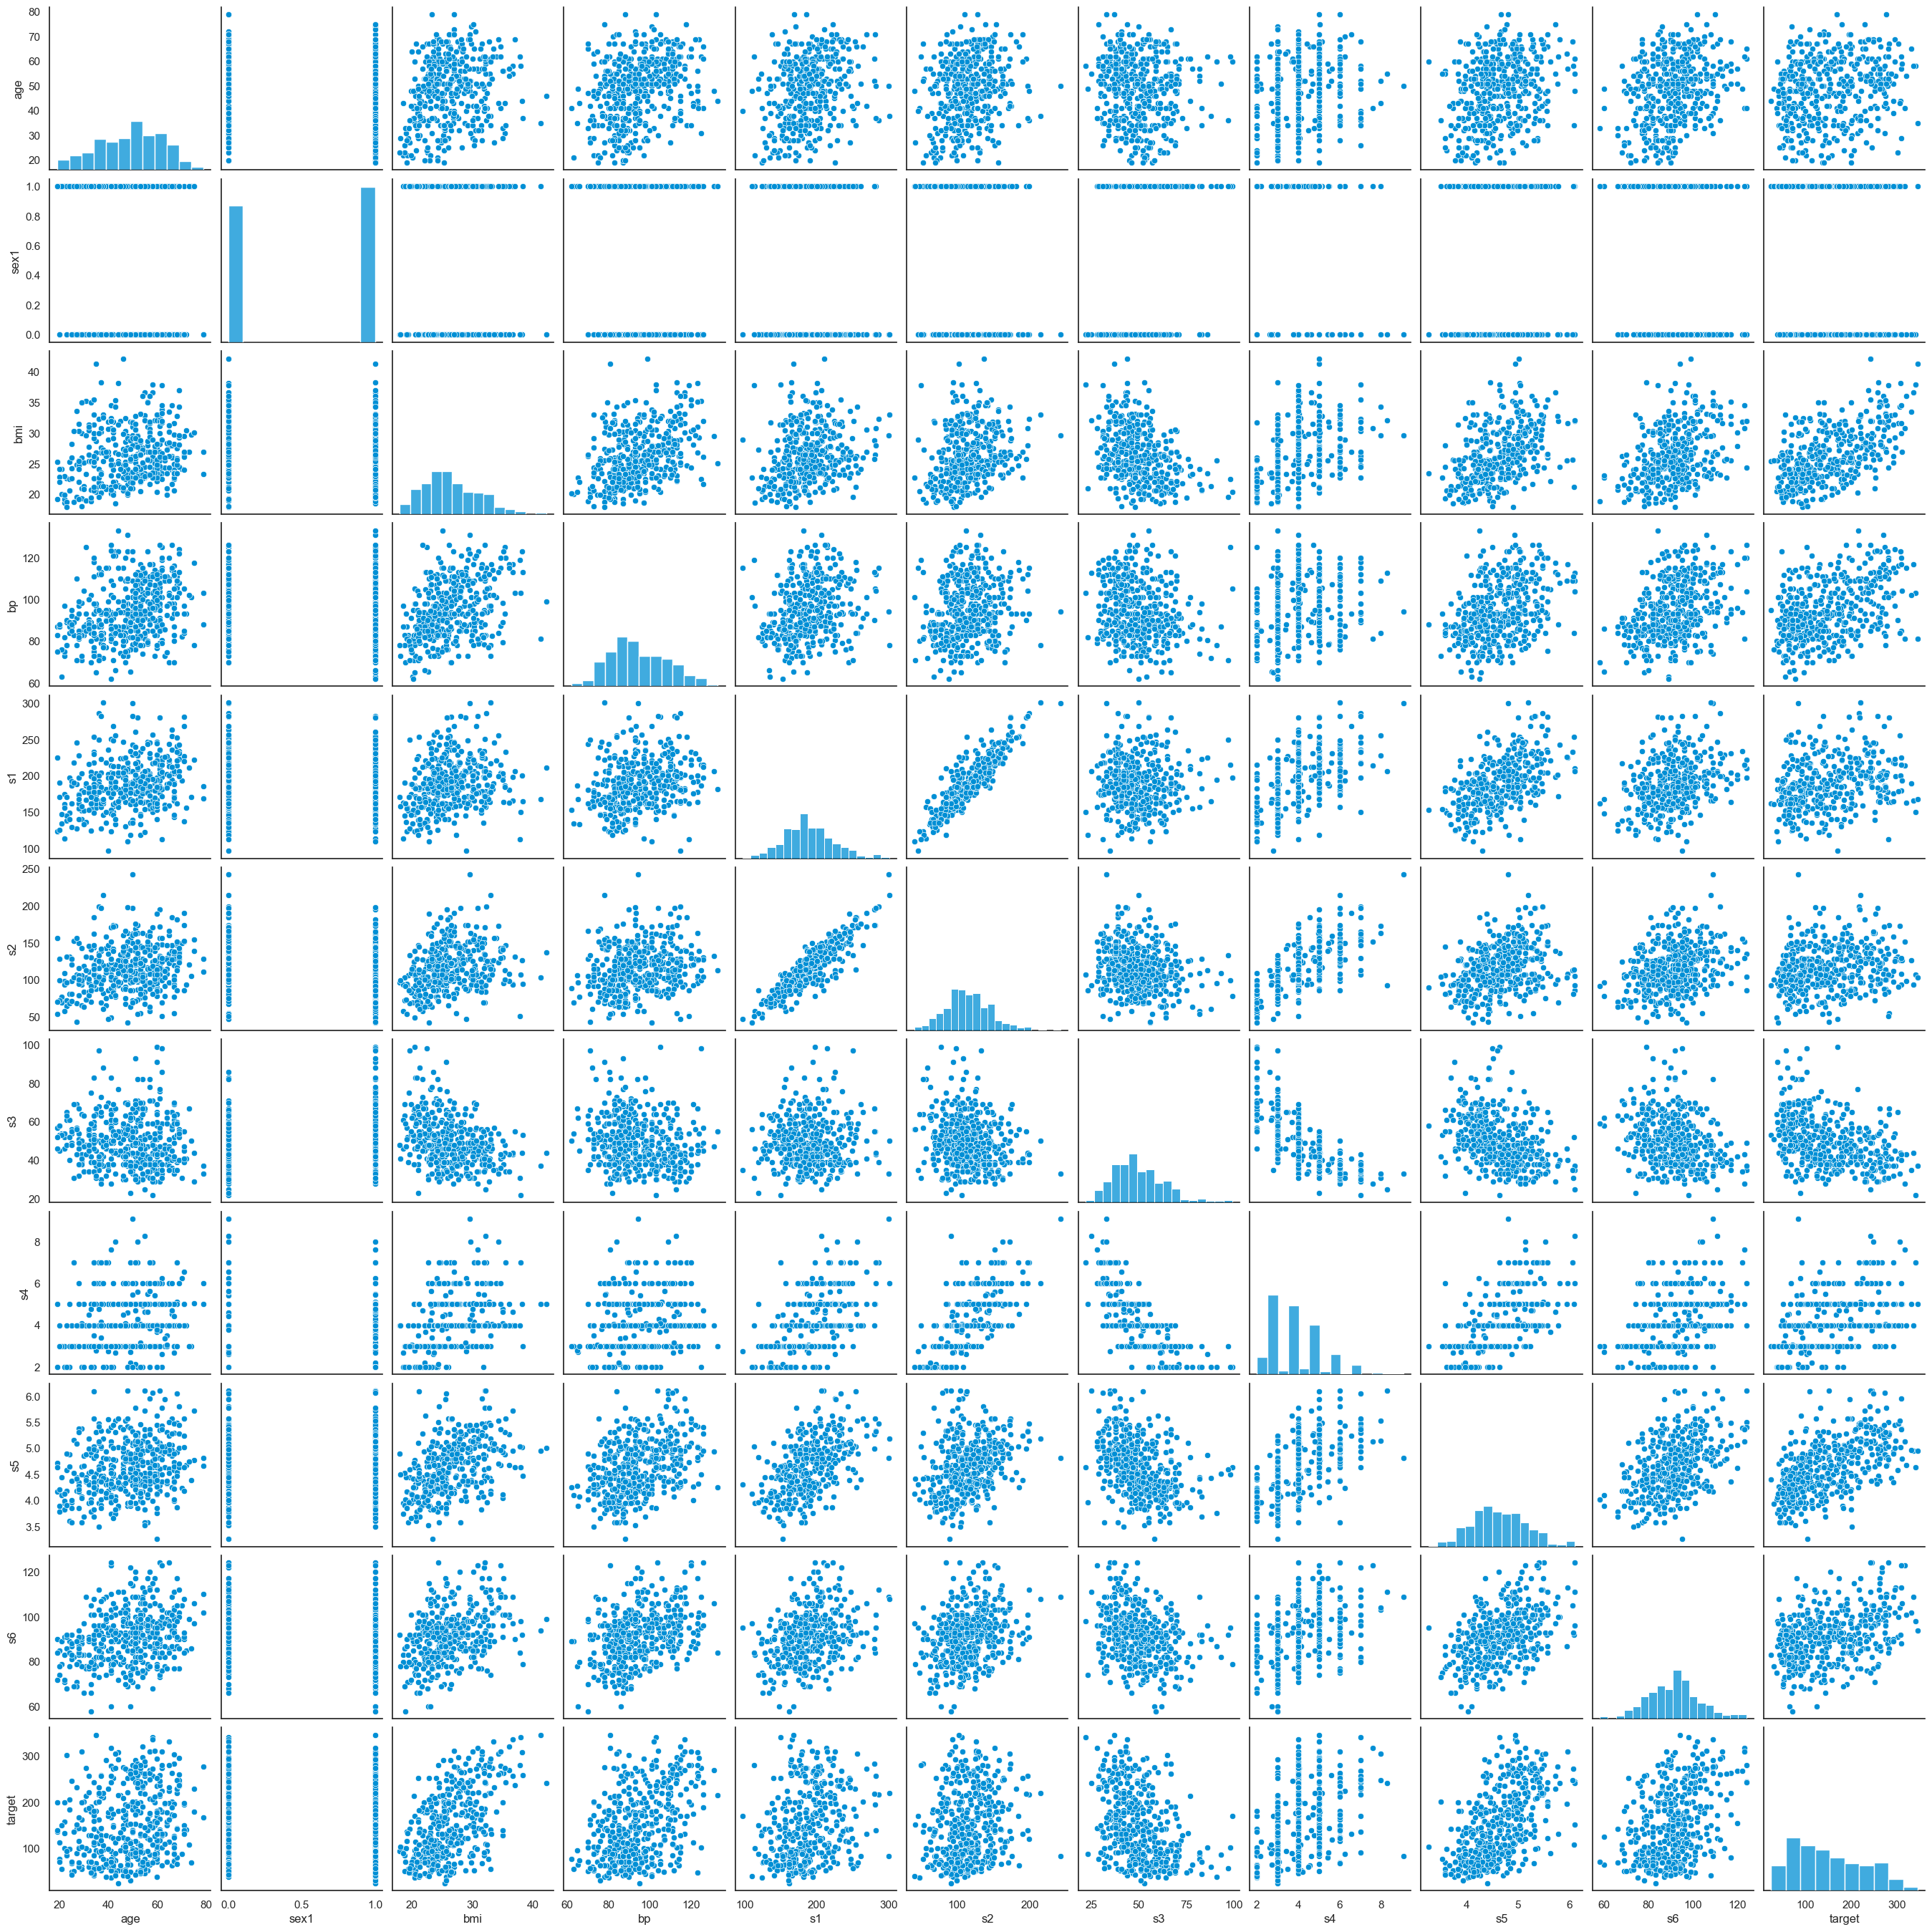

In [30]:
# This code may take a minute or two to finish running
sns.pairplot(diabetes)
plt.show()

### A simple function to perform EDA

DataFrame Head:


age  sex1   bmi     bp     s1     s2    s3   s4      s5    s6  target
0  59.0   0.0  32.1  101.0  157.0   93.2  38.0  4.0  4.8598  87.0   151.0
1  48.0   1.0  21.6   87.0  183.0  103.2  70.0  3.0  3.8918  69.0    75.0
2  72.0   0.0  30.5   93.0  156.0   93.6  41.0  4.0  4.6728  85.0   141.0

DataFrame Tail:


age  sex1   bmi     bp     s1     s2    s3    s4      s5    s6  target
439  60.0   0.0  24.9  99.67  162.0  106.6  43.0  3.77  4.1271  95.0   132.0
440  36.0   1.0  30.0  95.00  201.0  125.2  42.0  4.79  5.1299  85.0   220.0
441  36.0   1.0  19.6  71.00  250.0  133.2  97.0  3.00  4.5951  92.0    57.0

----------------------------------------------------------------------------------------------------
Missing values:


----------------------------------------------------------------------------------------------------
MSNO Matrix:



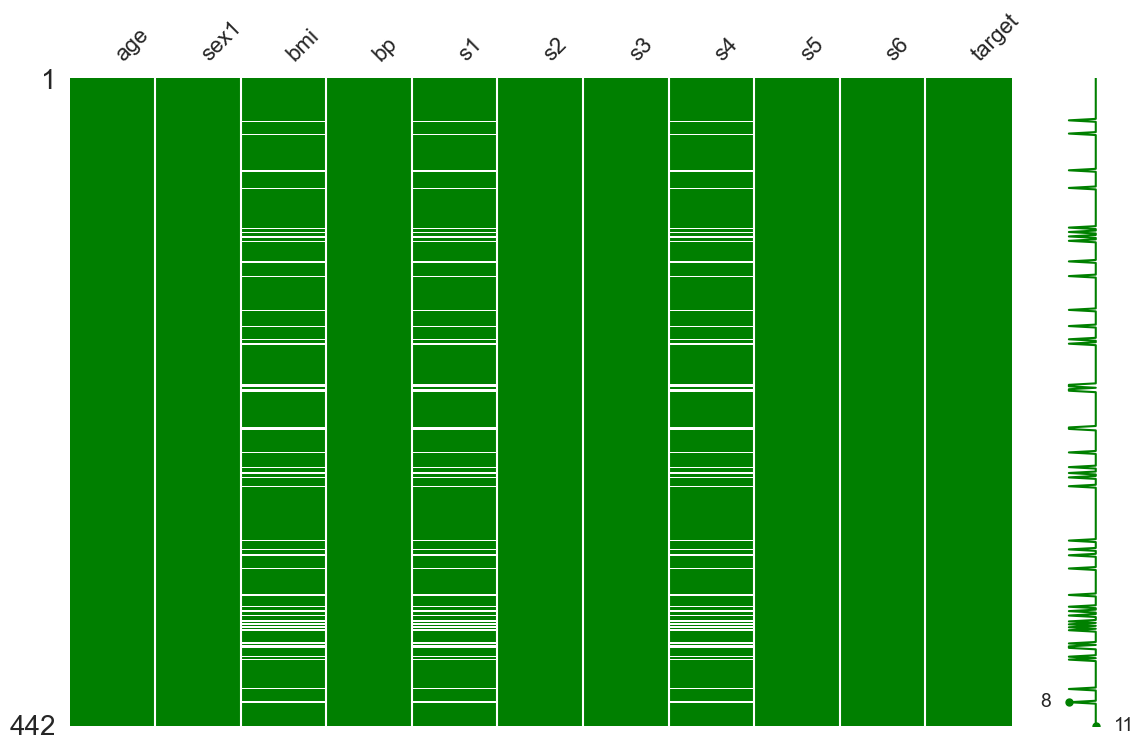

----------------------------------------------------------------------------------------------------
Shape of DataFrame:

(442, 11)

----------------------------------------------------------------------------------------------------
DataFrame Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442 entries, 0 to 441
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   age     442 non-null    float64
 1   sex1    442 non-null    float64
 2   bmi     398 non-null    float64
 3   bp      442 non-null    float64
 4   s1      398 non-null    float64
 5   s2      442 non-null    float64
 6   s3      442 non-null    float64
 7   s4      398 non-null    float64
 8   s5      442 non-null    float64
 9   s6      442 non-null    float64
 10  target  442 non-null    float64
dtypes: float64(11)
memory usage: 38.1 KB
----------------------------------------------------------------------------------------------------
Describe DataFrame:


----------------------------------------------------------------------------------------------------
DataFrame Correlation:



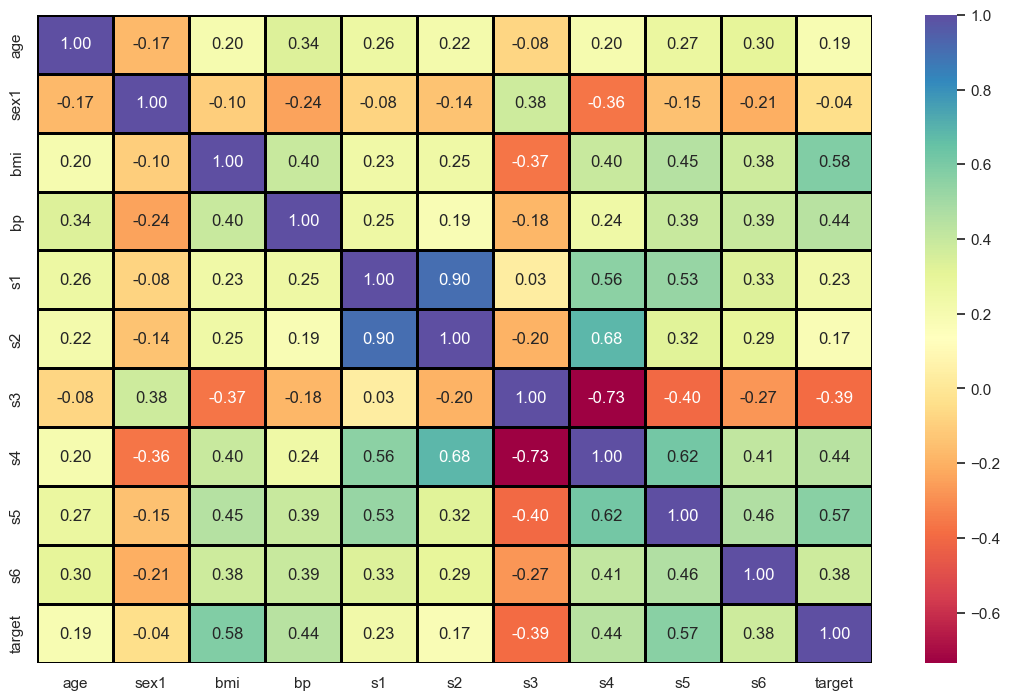

----------------------------------------------------------------------------------------------------
DataFrame Pairplot:



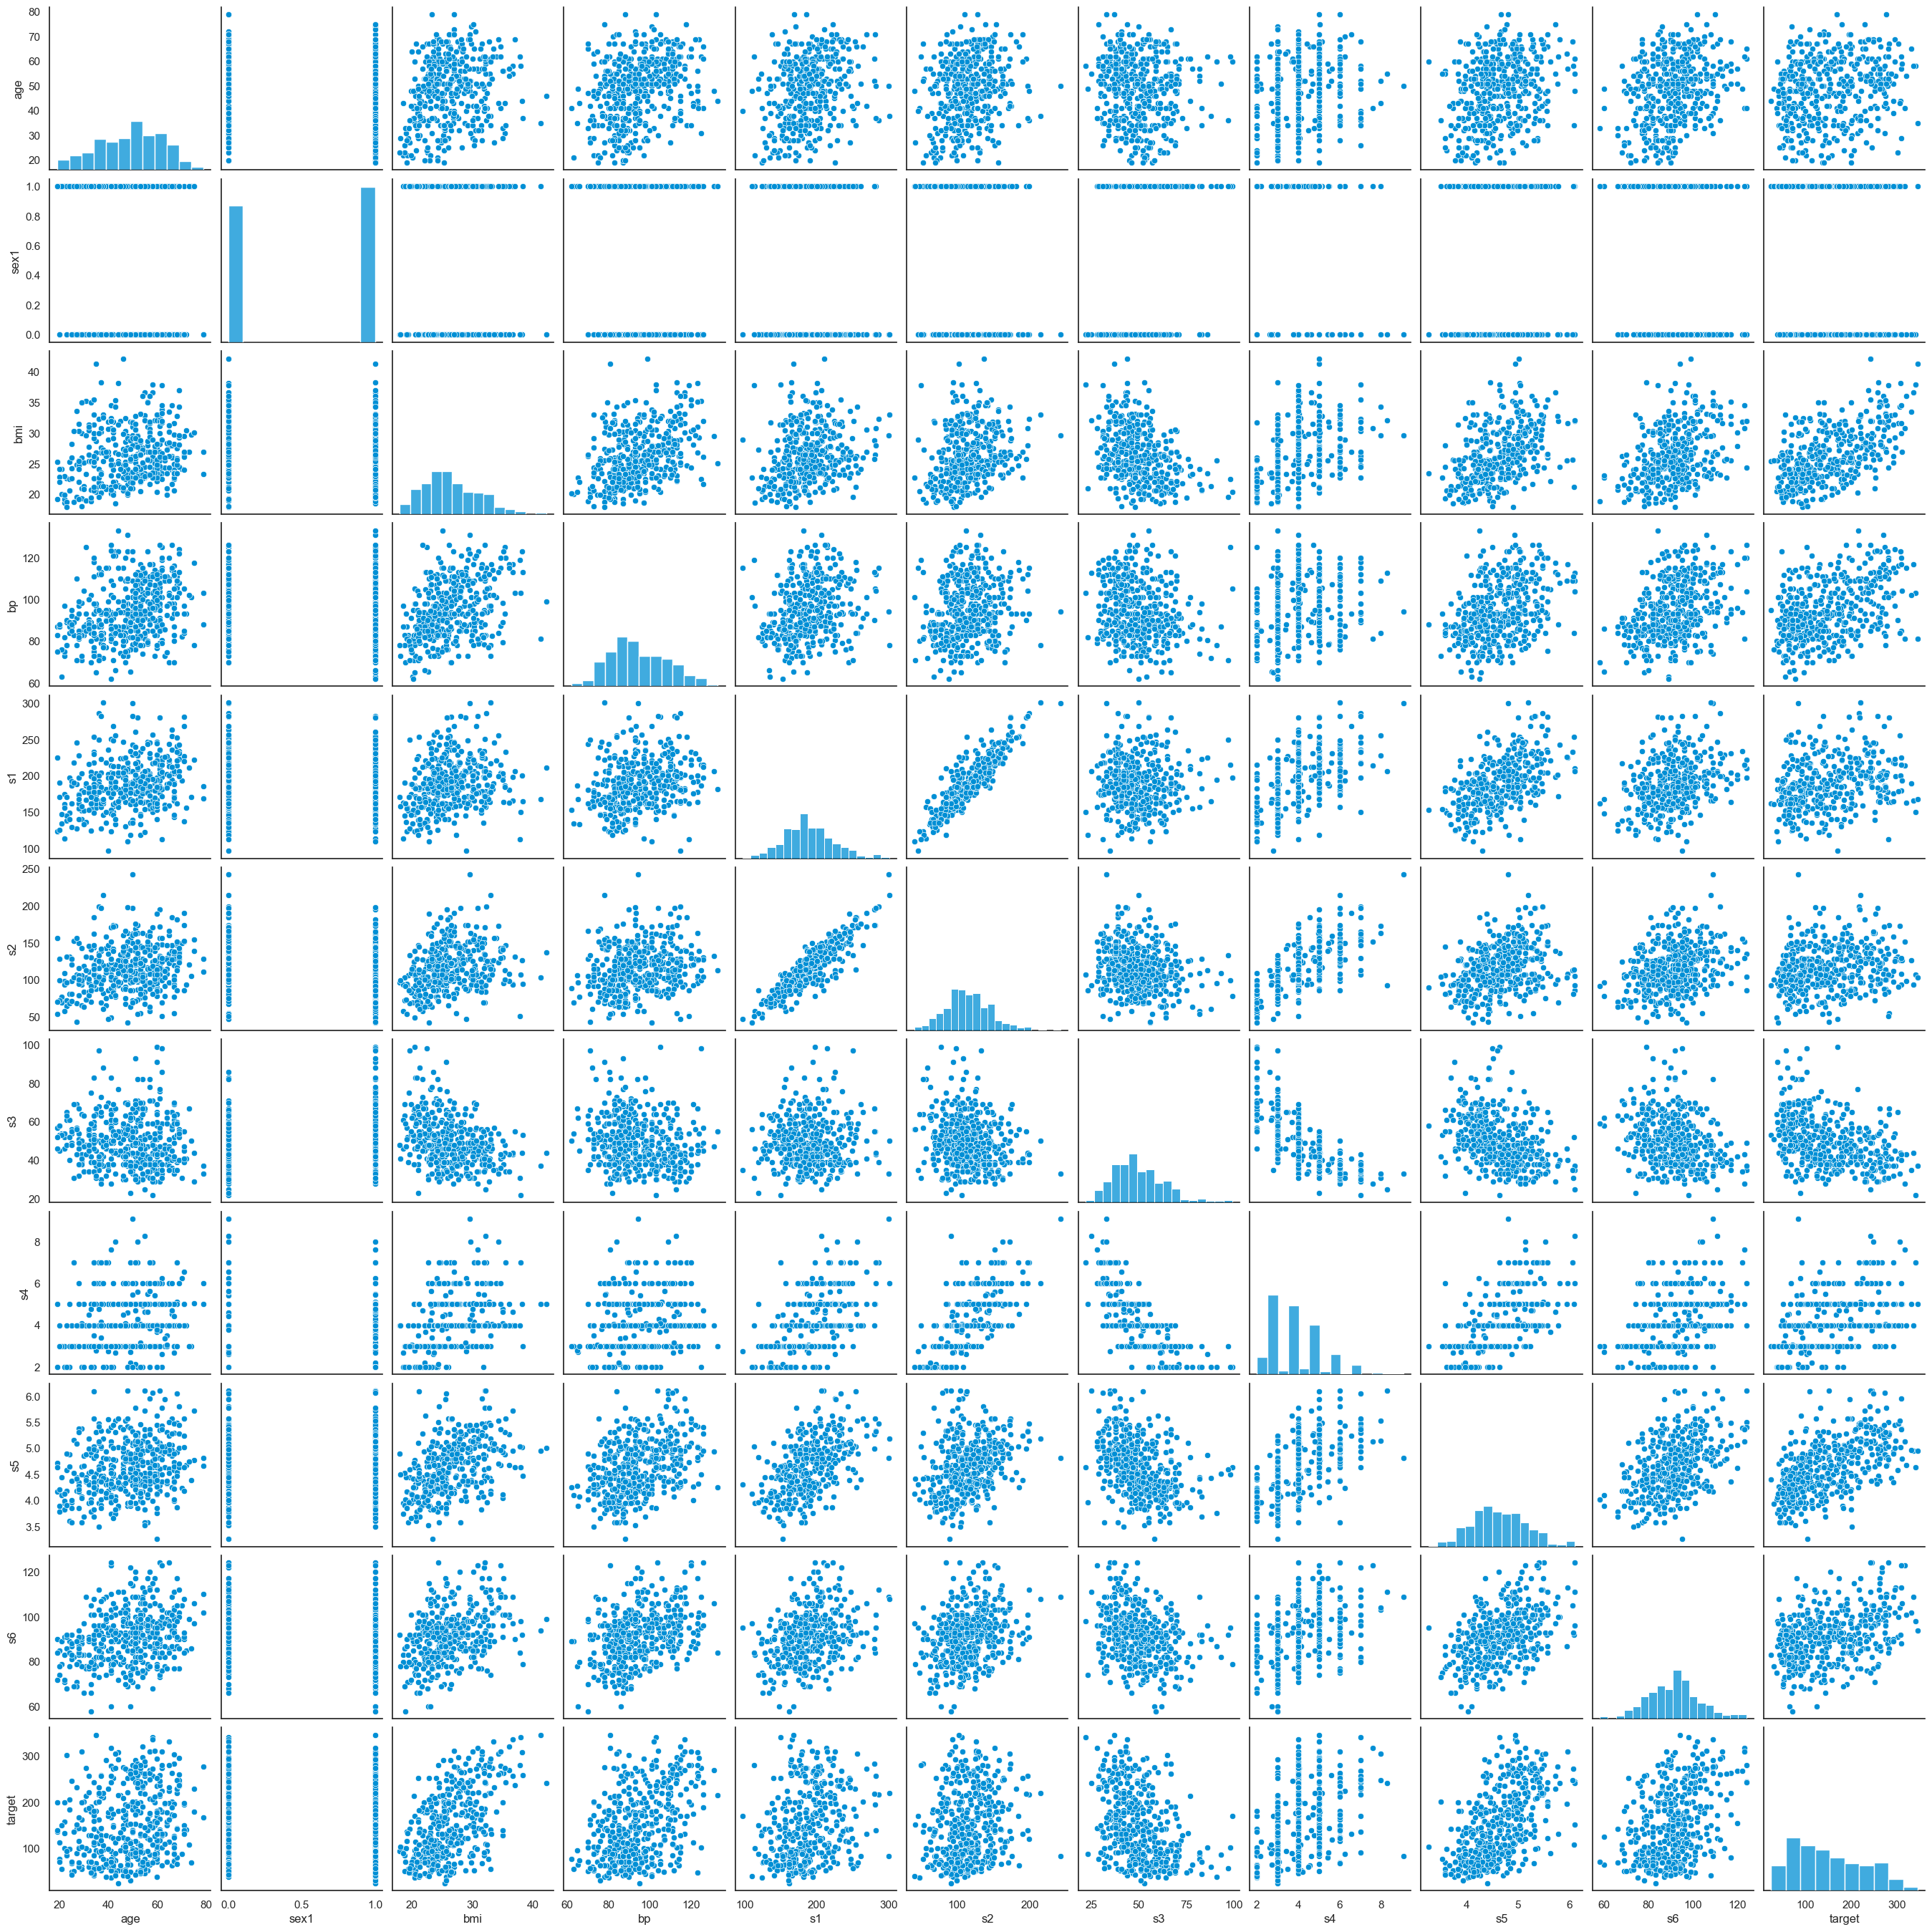

----------------------------------------------------------------------------------------------------
Histogram(s) & Boxplot(s):



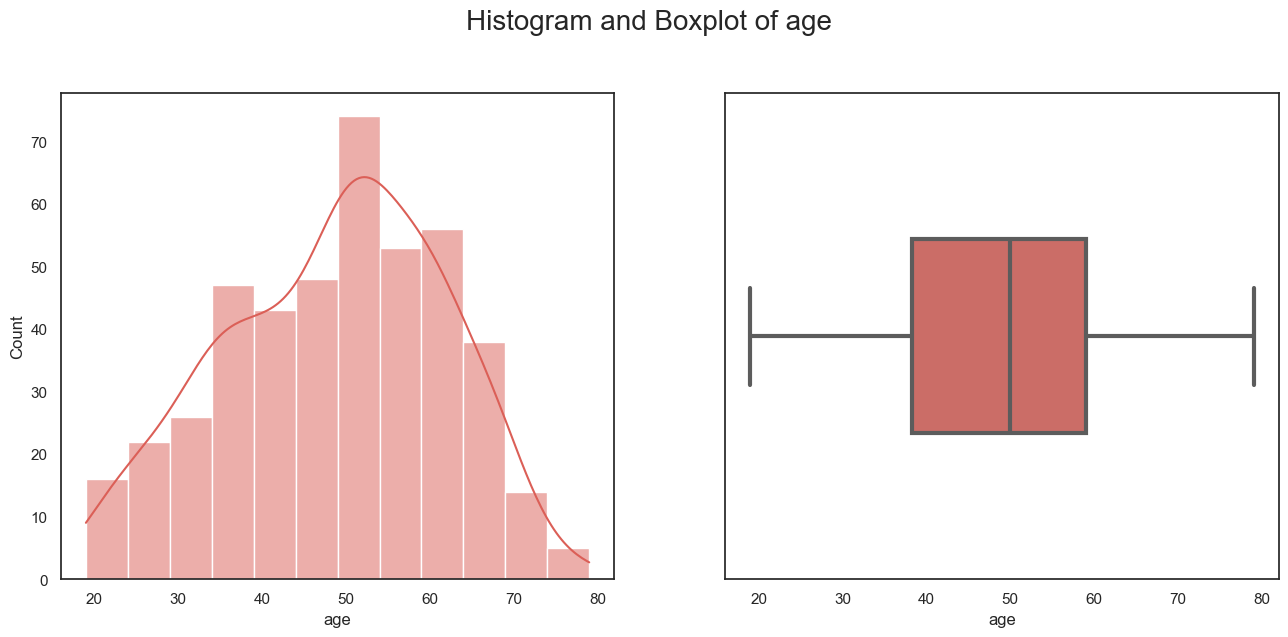

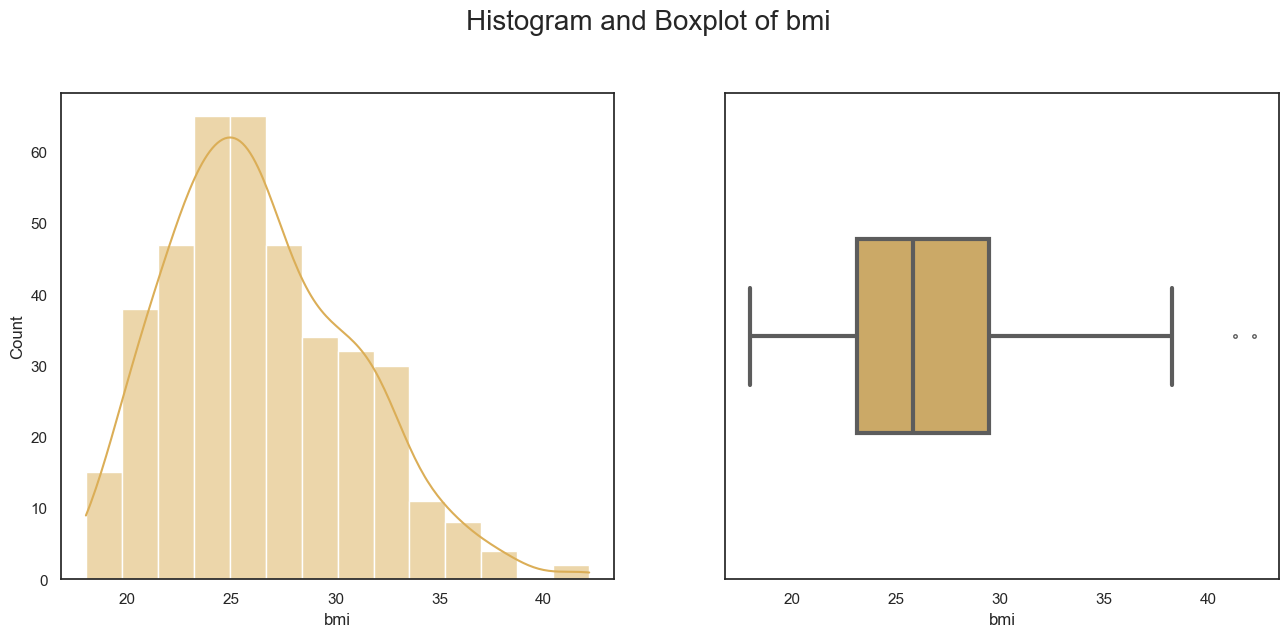

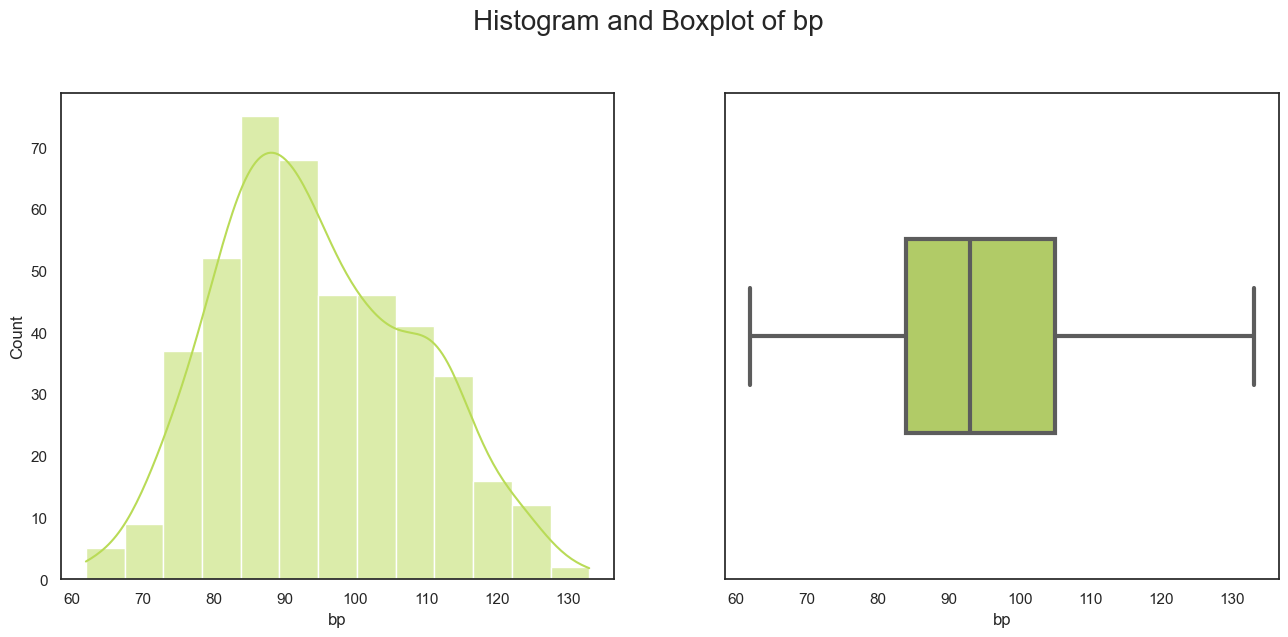

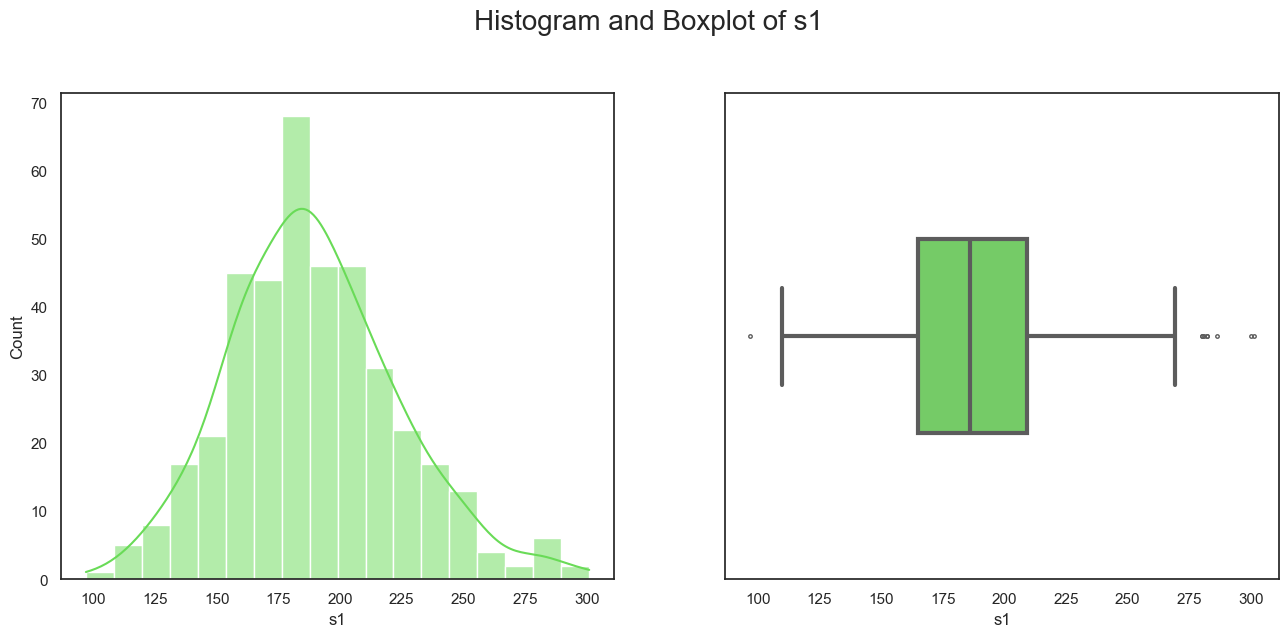

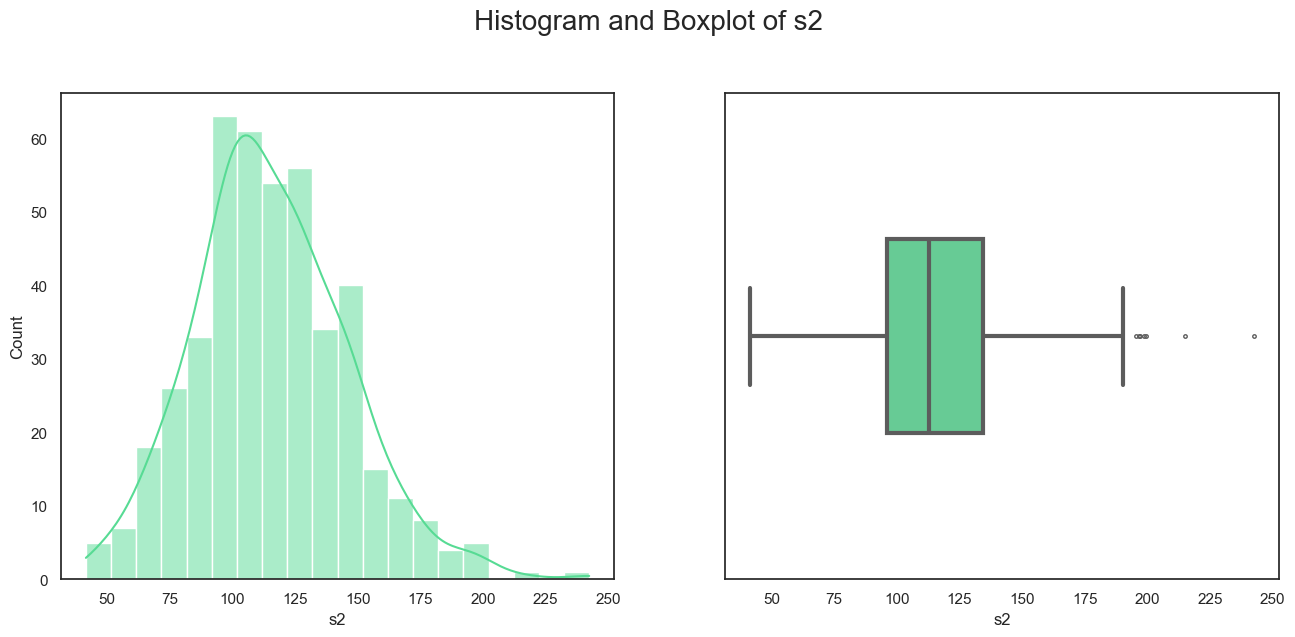

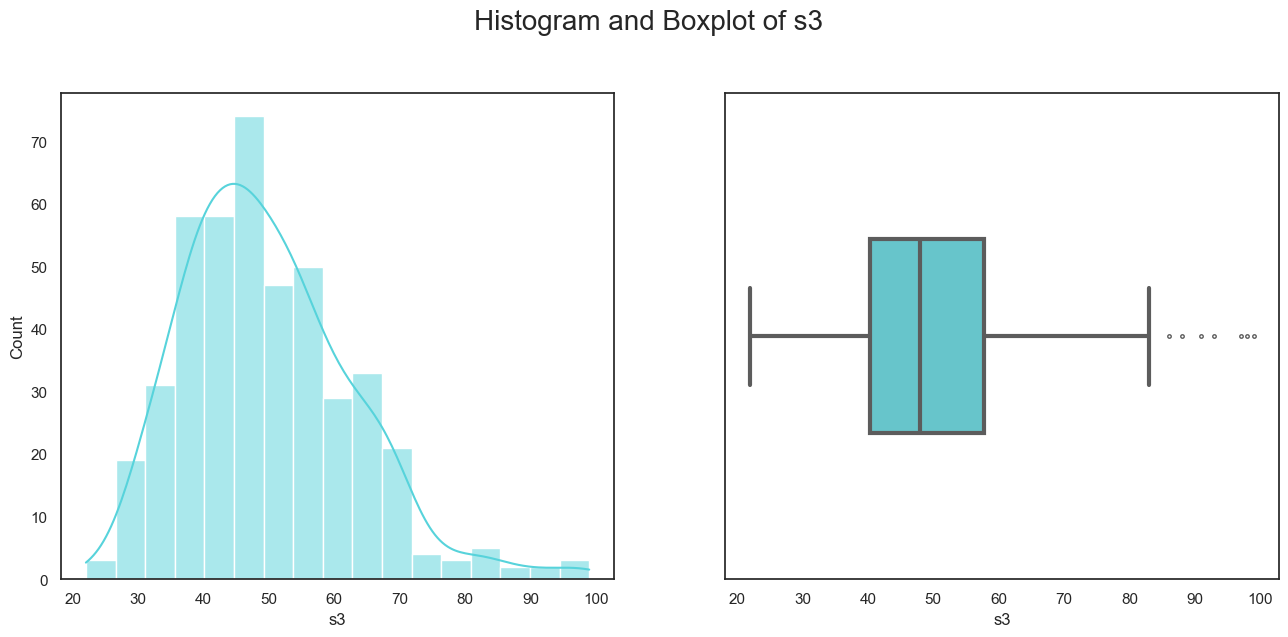

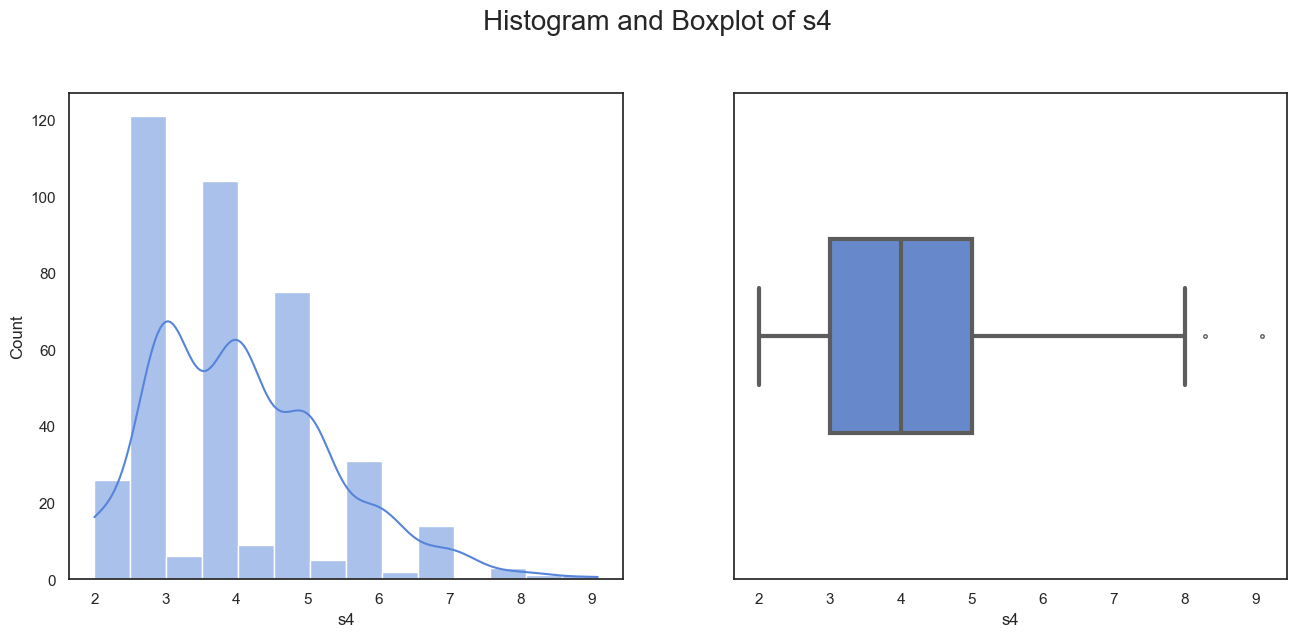

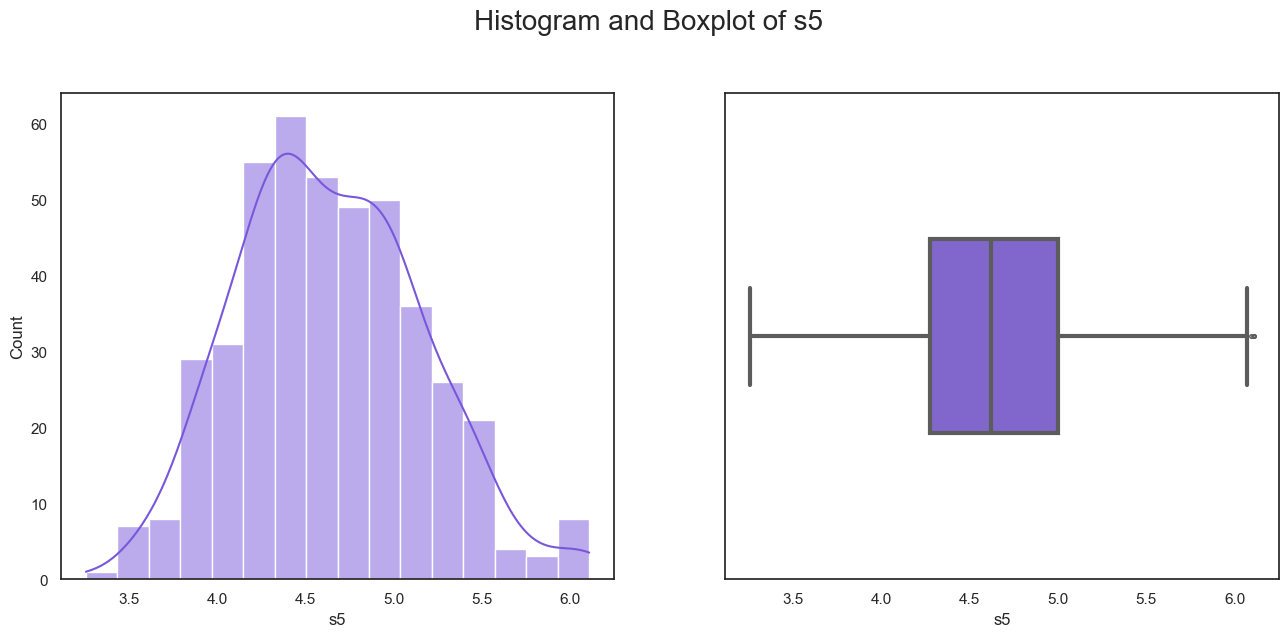

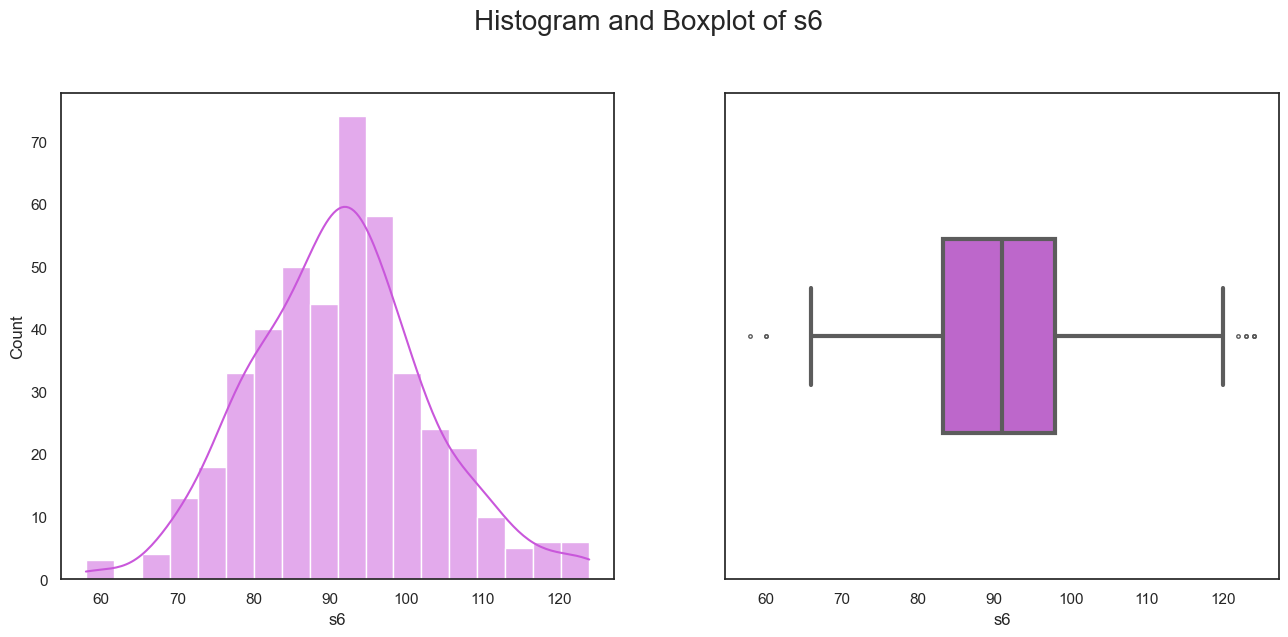

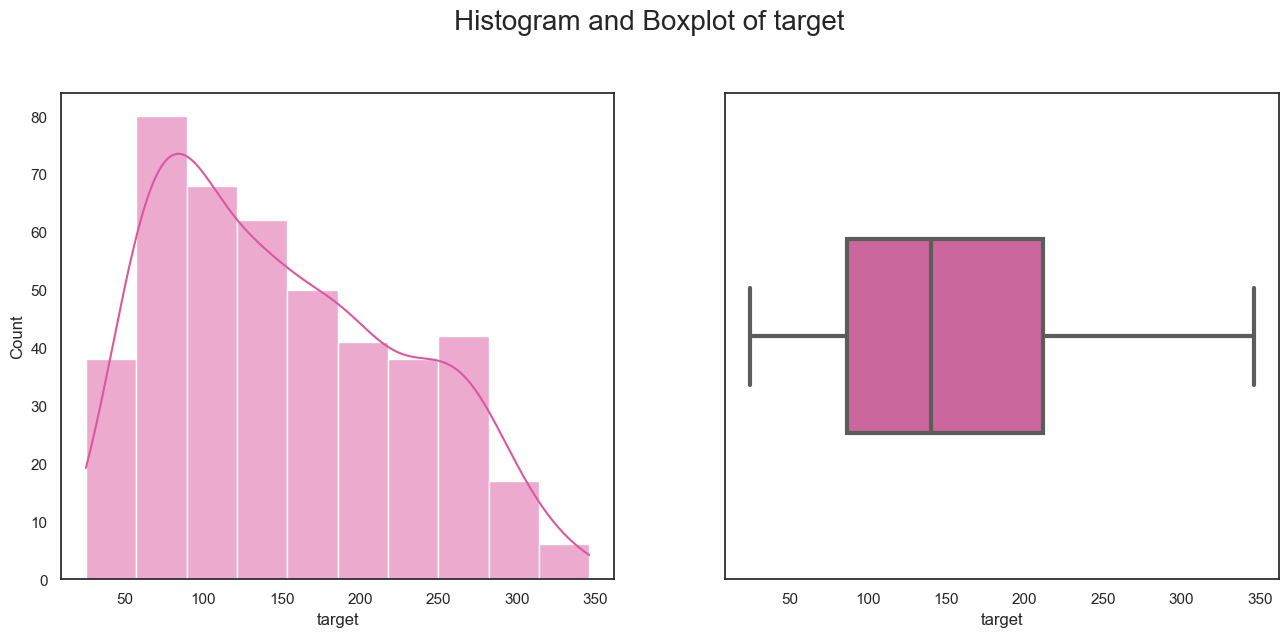

----------------------------------------------------------------------------------------------------
Countplot(s):



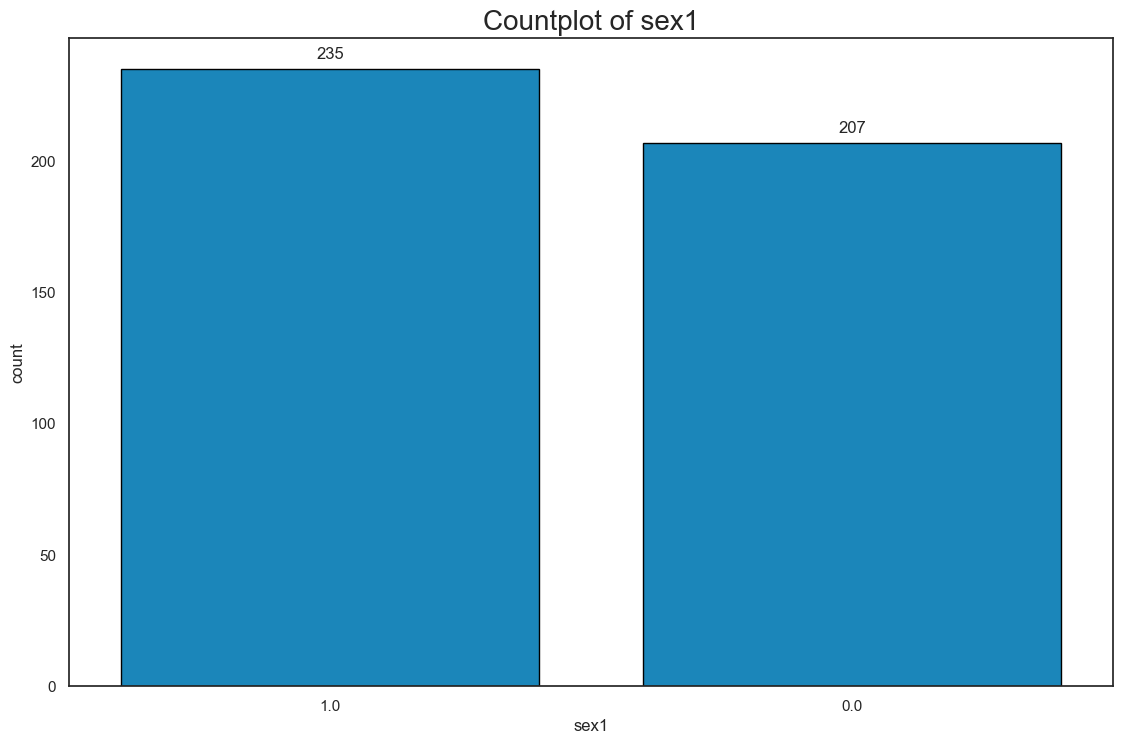

In [31]:
# This code may take a minute or two to finish running
fast_eda(diabetes)

The order and formatting of the items produced using `fast_eda` might differ from what you derived manually, but the information contained in all plots and matrices produced by `fast_eda` is identical.

---

# Classification
## Import the iris data set

In [33]:
# Load the data set from sklearn
iris_sklearn = load_iris()

# Extract the data and target labels as a numpy array
iris_npy = np.concatenate([iris_sklearn['data'], np.atleast_2d(iris_sklearn['target']).T], axis=1)

# Define column names
col_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'target']

# Convert the numpy array to a pandas dataframe with column names
iris = pd.DataFrame(iris_npy, columns=col_names)

# Print a description of the dataset
print(iris_sklearn['DESCR'])

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

:Number of Instances: 150 (50 in each of three classes)
:Number of Attributes: 4 numeric, predictive attributes and the class
:Attribute Information:
    - sepal length in cm
    - sepal width in cm
    - petal length in cm
    - petal width in cm
    - class:
            - Iris-Setosa
            - Iris-Versicolour
            - Iris-Virginica

:Summary Statistics:

============== ==== ==== ======= ===== ====================
                Min  Max   Mean    SD   Class Correlation
============== ==== ==== ======= ===== ====================
sepal length:   4.3  7.9   5.84   0.83    0.7826
sepal width:    2.0  4.4   3.05   0.43   -0.4194
petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
============== ==== ==== ======= ===== ====================

:Missing Attribute Values: None
:Class Distribution: 33.3% for each of 3 classes.
:Cr

Take a look at the `target` column.


In [34]:
iris['target'].sample(5)

71     1.0
126    2.0
78     1.0
32     0.0
65     1.0
Name: target, dtype: float64

The previous example indicates that the `target` column, which is categorical, is already numerically encoded. Let's map this encoding to class names.


In [35]:
class_names = dict(zip(list(map(float, range(len(iris_sklearn['target_names'])))), iris_sklearn['target_names']))
print(class_names)

{0.0: 'setosa', 1.0: 'versicolor', 2.0: 'virginica'}


The target column has the following mapping: target label `0.0` is associated with the `setosa` flower, `1.0` is associated with the `versicolor` flower, and `2.0` is associated with the `virginica` flower.


---

## Perform EDA on the iris data set

Complete the following exercise to perform EDA on the iris data set.


DataFrame Head:


sepal_length  sepal_width  petal_length  petal_width  target
0           5.1          3.5           1.4          0.2     0.0
1           4.9          3.0           1.4          0.2     0.0
2           4.7          3.2           1.3          0.2     0.0

DataFrame Tail:


sepal_length  sepal_width  petal_length  petal_width  target
147           6.5          3.0           5.2          2.0     2.0
148           6.2          3.4           5.4          2.3     2.0
149           5.9          3.0           5.1          1.8     2.0

----------------------------------------------------------------------------------------------------
Missing values:


----------------------------------------------------------------------------------------------------
Shape of DataFrame:

(150, 5)

----------------------------------------------------------------------------------------------------
DataFrame Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  150 non-null    float64
 1   sepal_width   150 non-null    float64
 2   petal_length  150 non-null    float64
 3   petal_width   150 non-null    float64
 4   target        150 non-null    float64
dtypes: float64(5)
memory usage: 6.0 KB
----------------------------------------------------------------------------------------------------
Describe DataFrame:



----------------------------------------------------------------------------------------------------
DataFrame Correlation:



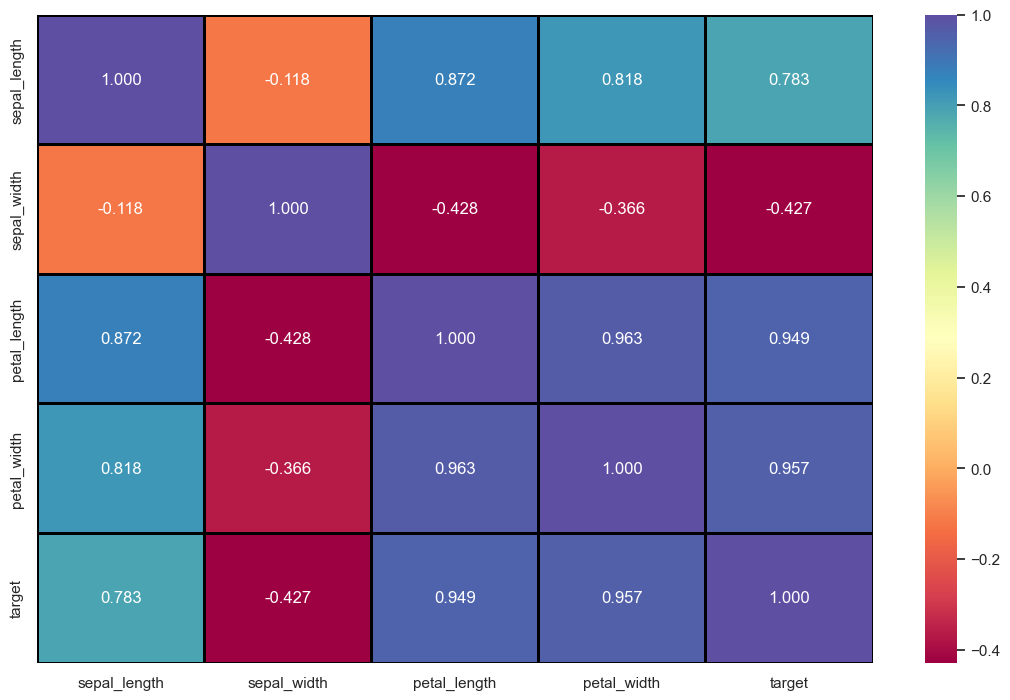

----------------------------------------------------------------------------------------------------
DataFrame Pairplot:



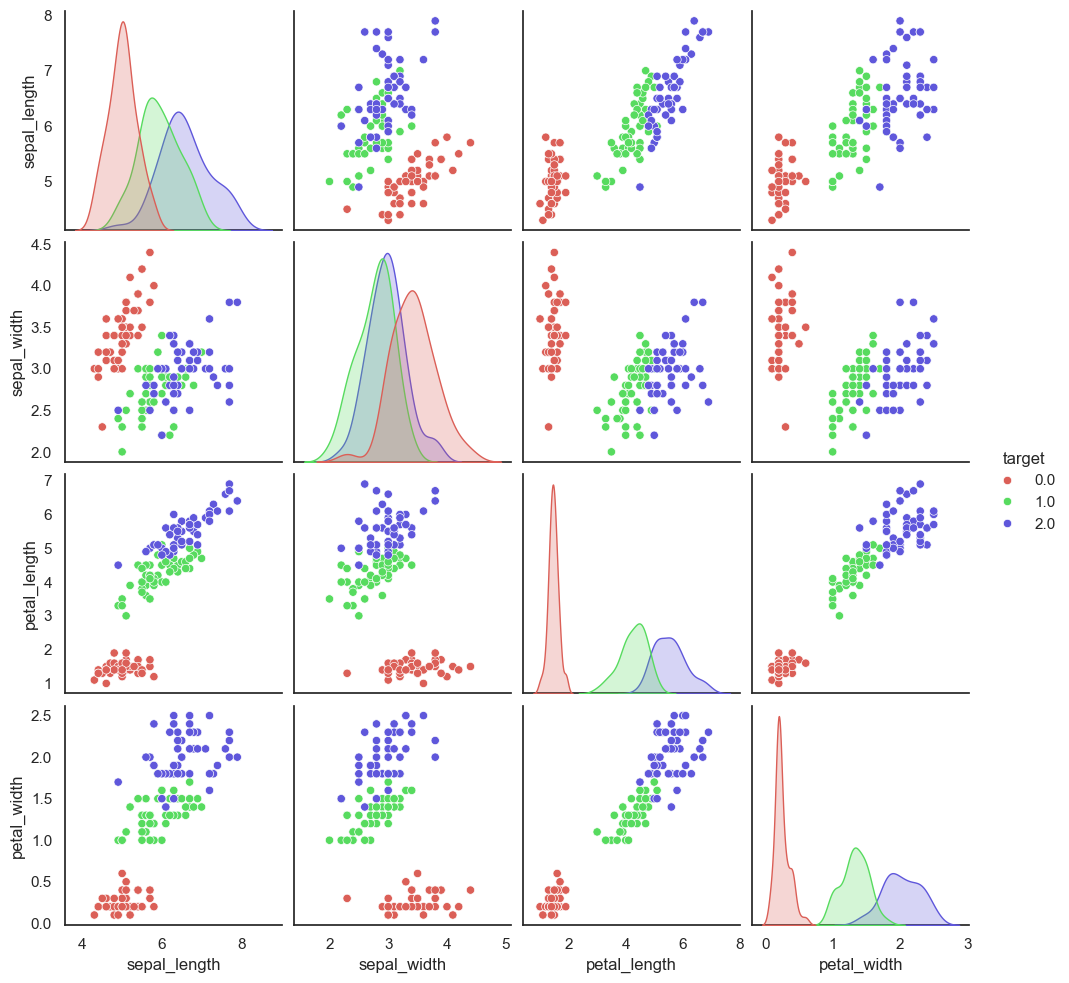

----------------------------------------------------------------------------------------------------
Histogram(s) & Boxplot(s):



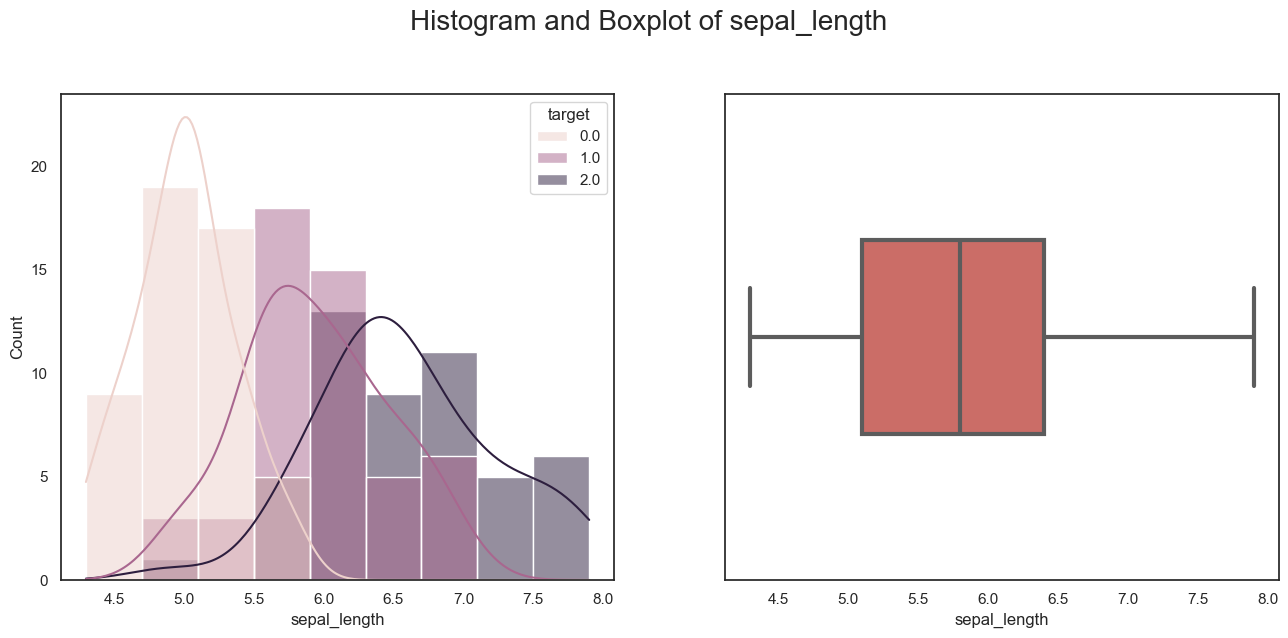

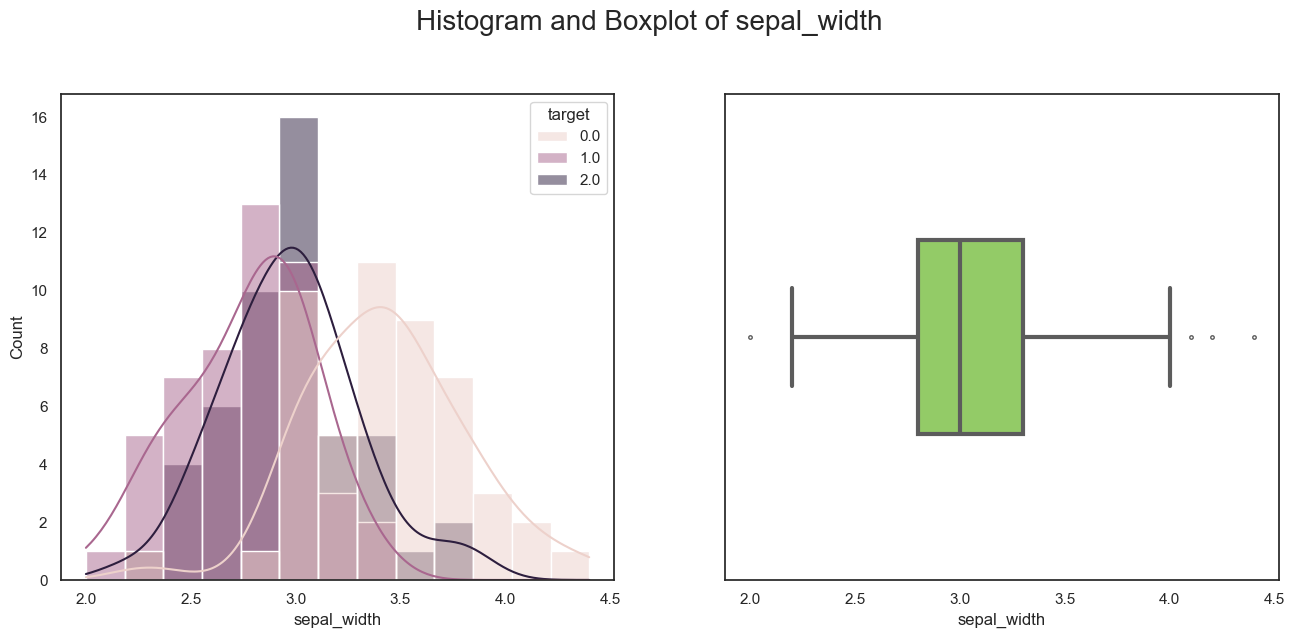

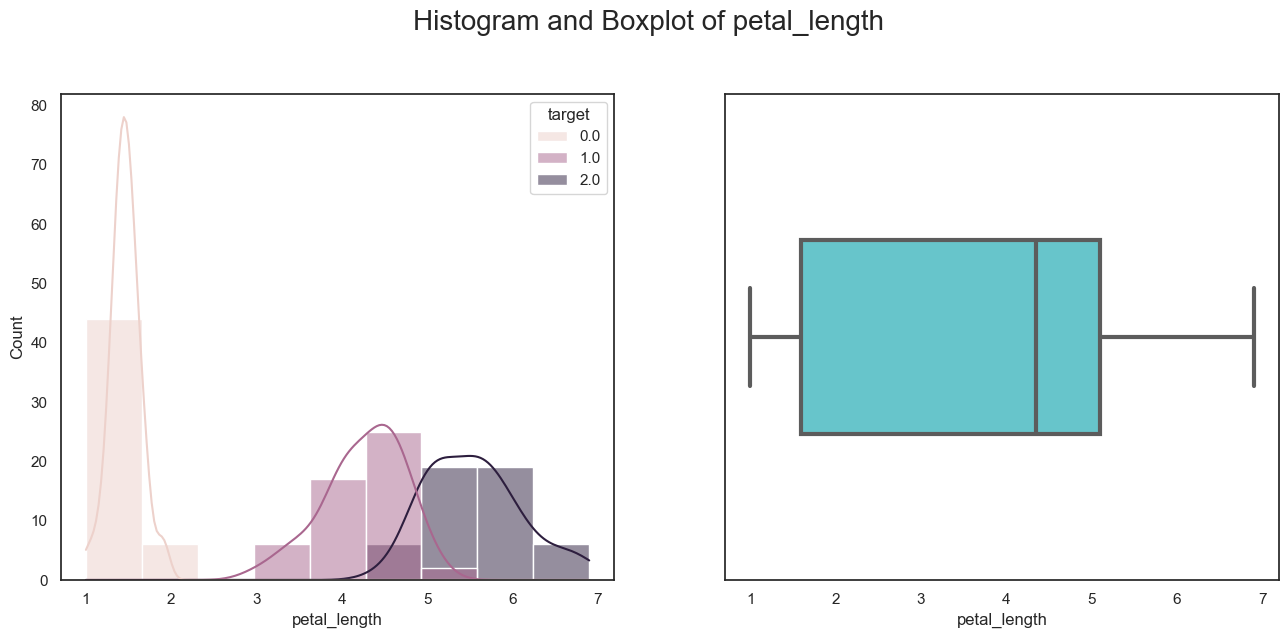

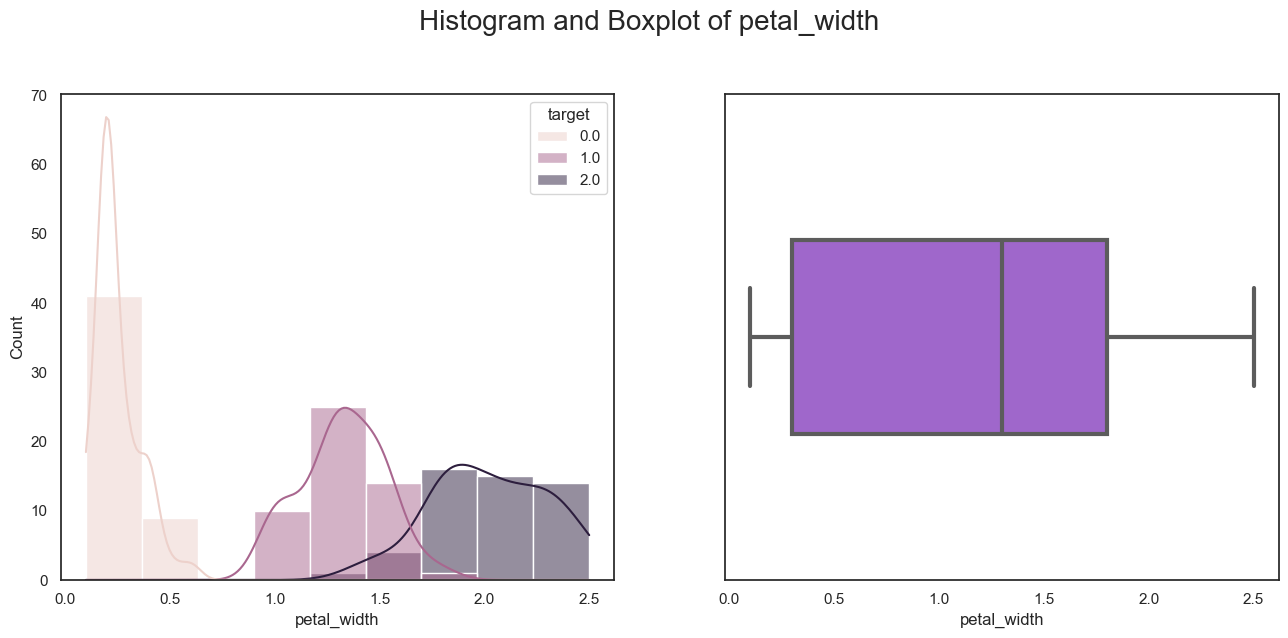

----------------------------------------------------------------------------------------------------
Countplot(s):



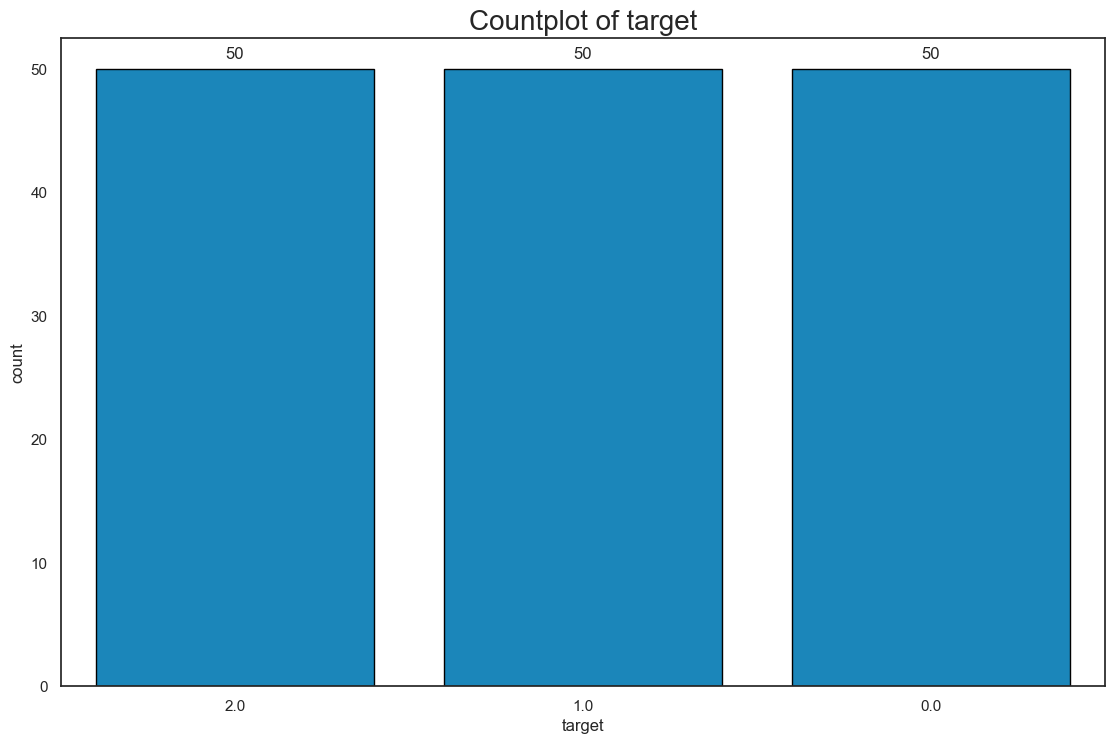

In [36]:
fast_eda(iris, target='target')

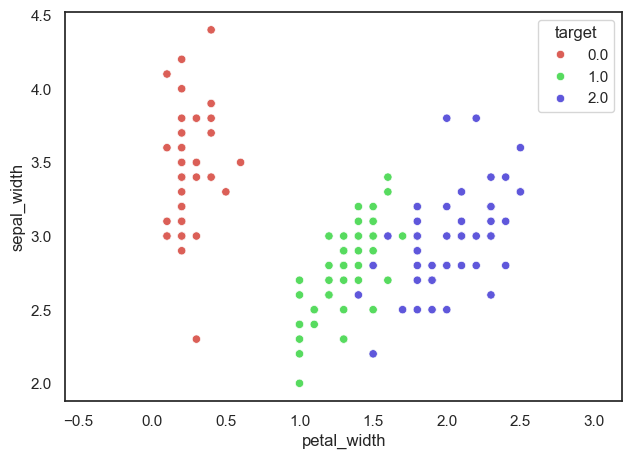

In [37]:
plt.axis('equal')
sns.scatterplot(iris, x='petal_width', y='sepal_width', hue='target', palette=sns.color_palette("hls", iris['target'].nunique()))
plt.show()

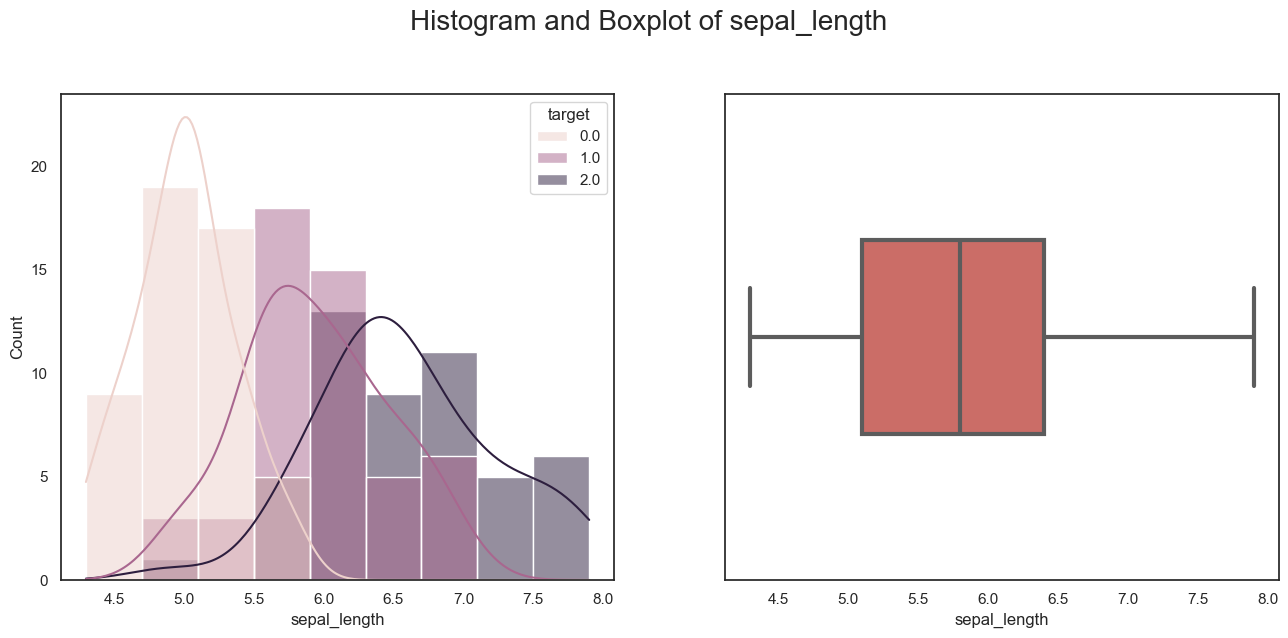

In [38]:
for idx, col in enumerate(['sepal_length']):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (14, 6))
    sns.histplot(iris, x = iris[col], kde = True,
                 color = sns.color_palette("hls", iris['target'].nunique()), ax = ax1, hue = 'target')
    sns.boxplot(x = iris[col], width = 0.4, linewidth = 3, fliersize = 2.5,
                color = sns.color_palette("hls", iris['target'].nunique())[idx], ax = ax2)
    fig.suptitle(f"Histogram and Boxplot of {col}", size = 20, y = 1.02)
    plt.show()

----

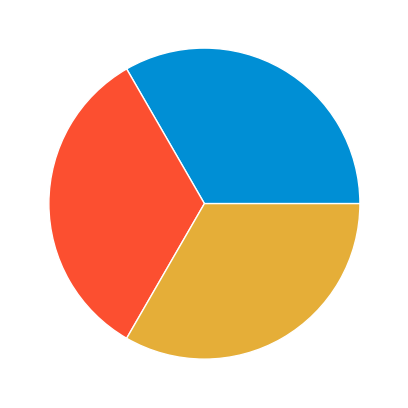

In [39]:
# Get value counts
vc = iris['target'].value_counts()

# Draw a pie chart using value counts and the `autopct_format` format
_ = plt.pie(vc)

An even prettier pie chart, one that shows the exact percentages of each class as well as the number of observations belonging to each class, can be made using:

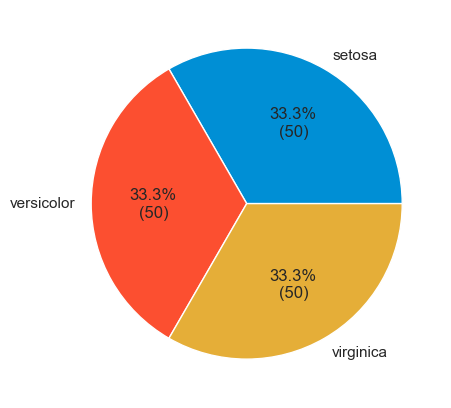

In [40]:
# Inspired by: https://stackoverflow.com/questions/73616867/pie-chart-from-count-of-values-showing-the-percentage/73617021#73617021

# Define a function that can be used to format value counts into percentages
def autopct_format(values):
        def my_format(pct):
            total = sum(values)
            val = int(round(pct*total/100.0))
            return '{:.1f}%\n({v:d})'.format(pct, v=val)
        return my_format

# Get value counts
vc = iris['target'].value_counts()

# Draw a pie chart using value counts and the autopct_format format
_ = plt.pie(vc, labels = vc.rename(class_names).index, autopct=autopct_format(vc))